In [ ]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# 使用echonet資料在unet訓練分割結果

In [ ]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

def compute_iou_and_dice(pred, target, num_classes, threshold=0.5):
    """
    計算 IOU 和 Dice 指數，並使用閾值將預測轉換為二進制（0 或 1）結果。
    :param pred: 模型預測結果 (batch_size, num_classes, height, width)
    :param target: 目標標註結果 (batch_size, num_classes, height, width)
    :param num_classes: 類別數量
    :param threshold: 用來將預測轉換為二進制結果的閾值 (預設為 0.5)
    :return: 每個類別的 IOU 和 Dice 指數
    """
    iou_per_class = []
    dice_per_class = []
    
    # 將預測轉換為二進制結果（閾值化）
    pred = (pred > threshold).float()  # Apply threshold to get binary result (0 or 1)

    for i in range(num_classes):
        # 取得每個類別的預測結果和真實標註
        pred_i = (pred == i+1).float()
        target_i = (target == i+1).float()

        # 計算交集和聯集
        intersection = (pred_i * target_i).sum()
        union = pred_i.sum() + target_i.sum()
        iou = intersection / (union - intersection) if union != 0 else torch.tensor(0.0)

        # 計算 Dice 指數
        dice = (2 * intersection) / (pred_i.sum() + target_i.sum()) if (pred_i.sum() + target_i.sum()) != 0 else torch.tensor(0.0)

        iou_per_class.append(iou.item())
        dice_per_class.append(dice.item())
    
    return iou_per_class, dice_per_class

def find_best_threshold(pred, target, num_classes, thresholds=np.arange(0.0, 1.1, 0.05)):
    """
    測試不同閾值並找出最佳閾值。
    :param pred: 模型預測結果 (batch_size, num_classes, height, width)
    :param target: 目標標註結果 (batch_size, num_classes, height, width)
    :param num_classes: 類別數量
    :param thresholds: 測試的閾值範圍
    :return: 最佳閾值
    """
    best_threshold = 0.5
    best_iou = 0
    best_dice = 0

    iou_list = []
    dice_list = []
    
    for threshold in thresholds:
        iou_per_class, dice_per_class = compute_iou_and_dice(pred, target, num_classes, threshold)
        
        avg_iou = np.mean(iou_per_class)
        avg_dice = np.mean(dice_per_class)
        
        iou_list.append(avg_iou)
        dice_list.append(avg_dice)
        
        # Find the threshold with the highest IOU and Dice
        if avg_iou > best_iou:
            best_iou = avg_iou
            best_threshold = threshold
        
        if avg_dice > best_dice:
            best_dice = avg_dice
            best_threshold = threshold
    
    # Plot IOU and Dice for each threshold
    import matplotlib.pyplot as plt
    plt.plot(thresholds, iou_list, label='IOU')
    plt.plot(thresholds, dice_list, label='Dice')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.legend()
    plt.title('IOU and Dice Scores for Different Thresholds')
    plt.show()
    
    return best_threshold, best_iou, best_dice

def display_image(image, ax, title="Input Image"):
    """
    Display a single image with grayscale to RGB conversion for visualization.
    """
    ax.imshow(image, cmap='gray')
    ax.set_title(title)
    ax.axis('off')

def display_mask(mask, ax, title="Mask"):
    """
    Display the mask using a color map (e.g., 'nipy_spectral').
    """
    ax.imshow(mask, cmap='nipy_spectral')  # Using 'nipy_spectral' for multi-class visualization
    ax.set_title(title)
    ax.axis('off')

def visualize_results(images, true_masks, predicted_masks, num_displayed=0, max_display=5):
    """
    Visualize the input image, true mask, and predicted mask.
    """
    for i in range(min(max_display, images.size(0))):  # Limit to max_display images
        sample_image = images[i].cpu().numpy().squeeze()  # Remove channel dimension for display
        sample_true_mask = true_masks[i].cpu().numpy()  # Get the true mask (multi-channel)
        sample_pred_mask = predicted_masks[i].cpu().numpy()  # Get the predicted mask (multi-channel)

        # Plot the input image, true mask, and predicted mask side by side
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # Display input image
        display_image(sample_image, axes[0], "Input Image")

        # Display true mask for each class
        for class_idx in range(sample_true_mask.shape[0]):  # Loop through the channels (classes)
            display_mask(sample_true_mask[class_idx], axes[1], f"True Mask (Class {class_idx})")
            break  # Only show the first class mask for now

        # Display predicted mask for each class
        for class_idx in range(sample_pred_mask.shape[0]):  # Loop through the channels (classes)
            display_mask(sample_pred_mask[class_idx], axes[2], f"Predicted Mask (Class {class_idx})")
            break  # Only show the first class mask for now

        plt.show()
        num_displayed += 1  # Update the display count

    return num_displayed

def visualize_results_binary(images, true_masks, predicted_masks, num_displayed=0, max_display=5):
    """
    Visualize the input image, true mask, and predicted mask.
    """
    for i in range(min(max_display, images.size(0))):  # Limit to max_display images
        sample_image = images[i].cpu().numpy().squeeze()  # Remove channel dimension for display
        sample_true_mask = true_masks[i].cpu().numpy().squeeze()  # Remove channel dimension for display
        sample_pred_mask = predicted_masks[i].cpu().numpy().squeeze()  # Remove channel dimension for display

        # Binarize predicted mask for binary classification (0 or 1)
        sample_pred_mask = (sample_pred_mask > 0.5).astype(np.uint8)  # Binarize prediction

        # Plot the input image, true mask, and predicted mask side by side
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # Display input image
        display_image(sample_image, axes[0], "Input Image")

        # Display true mask
        display_mask(sample_true_mask, axes[1], f"True Mask")

        # Display predicted mask
        display_mask(sample_pred_mask, axes[2], f"Predicted Mask")

        plt.show()
        num_displayed += 1  # Update the display count

    return num_displayed



# 轉換 Windows 路徑至適合的格式
def convert_path(path):
    return path.replace('\\', '/')

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

# 定義 U-Net 模型（修改為二分類問題，每個類別作為二分類處理）
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)
        # self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits



In [ ]:
class ImageMaskDataset(Dataset):
    def __init__(self, frames_dir, masks_dir, file_list, transform=None):
        """
        :param frames_dir: 原始影像的資料夾路徑
        :param masks_dir: 遮罩影像的資料夾路徑
        :param file_list: 包含影像檔案名稱的列表（不包含路徑）
        :param transform: 資料增強的轉換方法
        """
        self.frames_dir = frames_dir
        self.masks_dir = masks_dir
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        frame_path = os.path.join(self.frames_dir, self.file_list[idx])
        mask_path = os.path.join(self.masks_dir, self.file_list[idx])

        # 讀取影像和遮罩
        frame = Image.open(frame_path).convert('L')  # 原始影像轉為 RGB
        mask = Image.open(mask_path).convert('L')  # 遮罩影像轉為單通道灰度

        if self.transform:
            frame = self.transform(frame)
            mask = self.transform(mask)

        # 將遮罩轉為二值格式
        mask = (mask > 0.5).float()  # 將像素值轉為二進制

        return frame, mask

# 訓練函數
def train():
    # 設定路徑
    frames_dir = "mask_and_label_frame/frames"
    masks_dir = "mask_and_label_frame/masks"

    # 分割數據集
    all_filenames = [f for f in os.listdir(frames_dir) if f.endswith('.png')]
    train_filenames, temp_filenames = train_test_split(all_filenames, test_size=0.2, random_state=42)
    val_filenames, test_filenames = train_test_split(temp_filenames, test_size=0.5, random_state=42)

    print(f"訓練集大小: {len(train_filenames)}")
    print(f"驗證集大小: {len(val_filenames)}")
    print(f"測試集大小: {len(test_filenames)}")

    # 定義資料增強與轉換
    transform = transforms.Compose([
        transforms.Resize((112, 112)),  # 確保影像大小一致
        transforms.ToTensor(),         # 轉為 Tensor
    ])

    # 創建數據集
    train_dataset = ImageMaskDataset(frames_dir, masks_dir, train_filenames, transform)
    val_dataset = ImageMaskDataset(frames_dir, masks_dir, val_filenames, transform)
    test_dataset = ImageMaskDataset(frames_dir, masks_dir, test_filenames, transform)

    # 創建 DataLoader
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    print("DataLoader 建立完成")

    # 初始化模型
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = UNet(1, 1).to(device)

    
    # 嘗試加載預訓練權重
    model_path = f'unet_best_model_LV.pth'
    if os.path.exists(model_path):
        model.load_state_dict(torch.load(model_path))  # 加載預訓練的權重
        print(f"Loaded pretrained weights for LV from {model_path}")
    else:
        print(f"No pretrained weights found for LV. Training from scratch.")


    # 設置損失函數和優化器
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001)

    # 訓練模型
    num_epochs = 100
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for images, masks in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)

            loss = criterion(outputs, masks)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)

        # 驗證模型
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)

                loss = criterion(outputs, masks)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        print(f'Epoch {epoch + 1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

        # 儲存模型
        torch.save(model.state_dict(), f'unet_latest_model_LV.pth')

        # 儲存最佳模型
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'unet_best_model_LV.pth')

        # 測試模型
        model.eval()
        iou_per_class_total = 0
        dice_per_class_total = 0
        num_batches = 0

        with torch.no_grad():
            for images, masks in test_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                predicted = torch.sigmoid(outputs)  # 轉換為二進制結果

                # 顯示前五張範例圖像與預測結果
                if num_batches == 0 and num_epochs - epoch < 5:  # 只顯示第一批
                    visualize_results(images, masks, predicted, num_displayed=0, max_display=5)
                    visualize_results_binary(images, masks, predicted, num_displayed=0, max_display=5)

                # 計算 IOU 和 Dice 指數
                iou_per_class, dice_per_class = compute_iou_and_dice(predicted, masks, 1)  # 這裡只有一個類別
                print('iou_per_class', iou_per_class, 'dice_per_class', dice_per_class)

                iou_per_class_total += np.array(iou_per_class)
                dice_per_class_total += np.array(dice_per_class)
                num_batches += 1

                if num_batches == 3 and epoch != num_epochs - 1:
                    break

    # 計算平均 IOU 和 Dice
    iou_per_class_avg = iou_per_class_total / num_batches
    dice_per_class_avg = dice_per_class_total / num_batches
    print(f'IOU: {iou_per_class_avg[0]:.4f}, Dice: {dice_per_class_avg[0]:.4f}')

    best_threshold, best_iou, best_dice = find_best_threshold(predicted, masks, 1)
    print(f"Best Threshold: {best_threshold}")
    print(f"Best IOU: {best_iou}")
    print(f"Best Dice: {best_dice}")


train()


# 可視化echonet LV分割測試結果

訓練集大小: 16038
驗證集大小: 2005
測試集大小: 2005
DataLoader 建立完成


/tmp/ipykernel_4132059/241630473.py:75: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))  # 加載預訓練的權重


Loaded pretrained weights for LV from unet_best_model_LV.pth


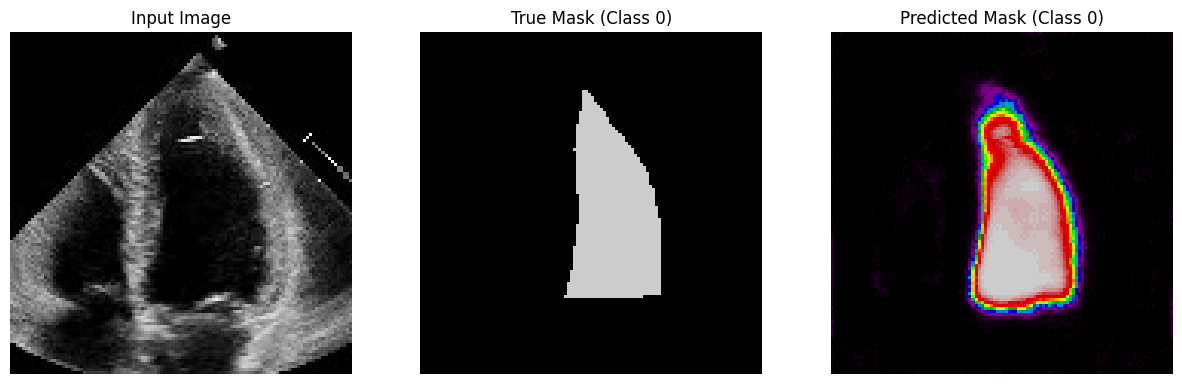

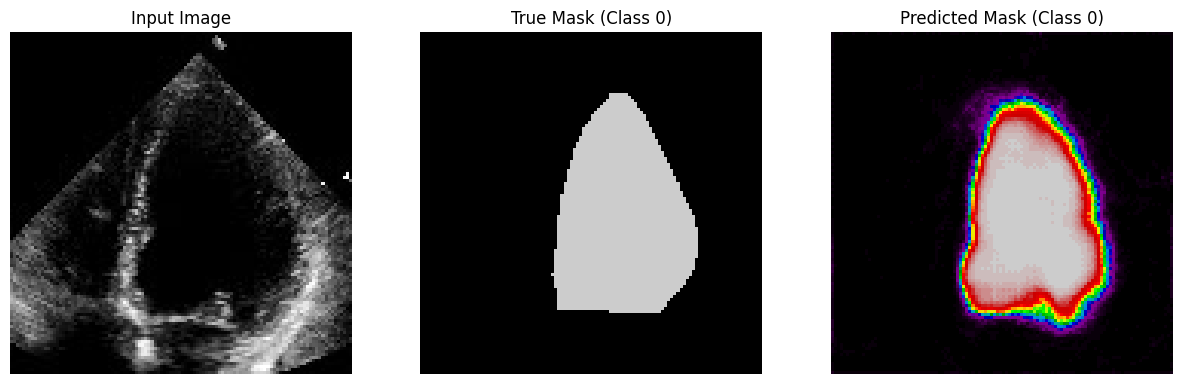

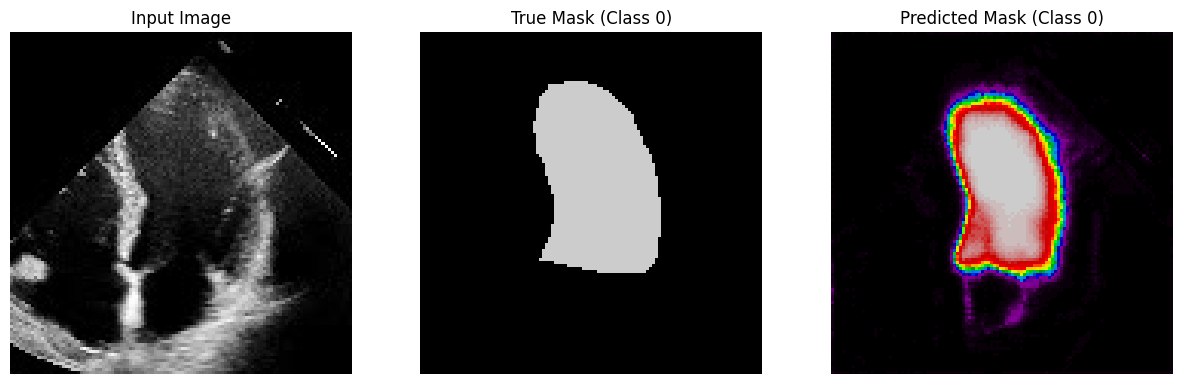

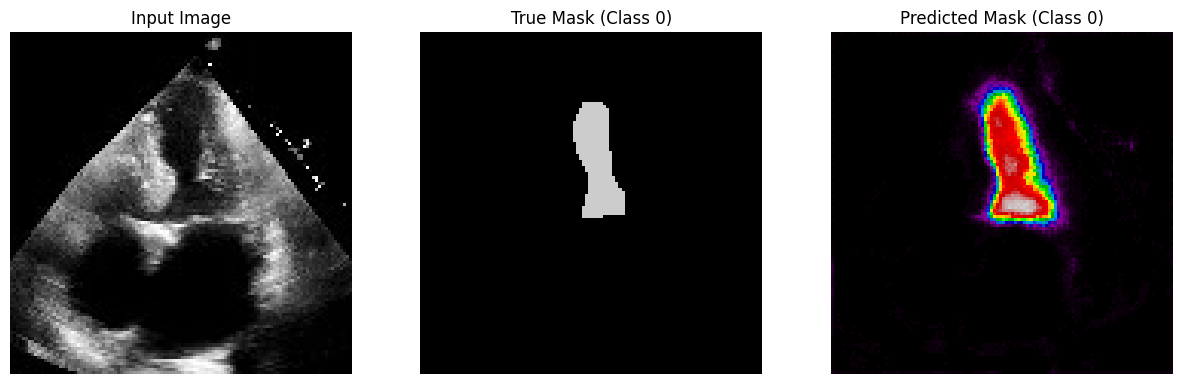

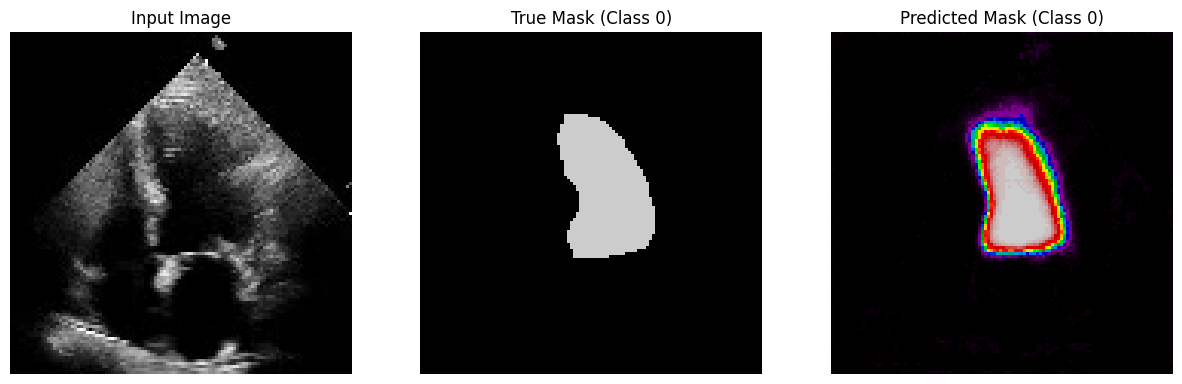

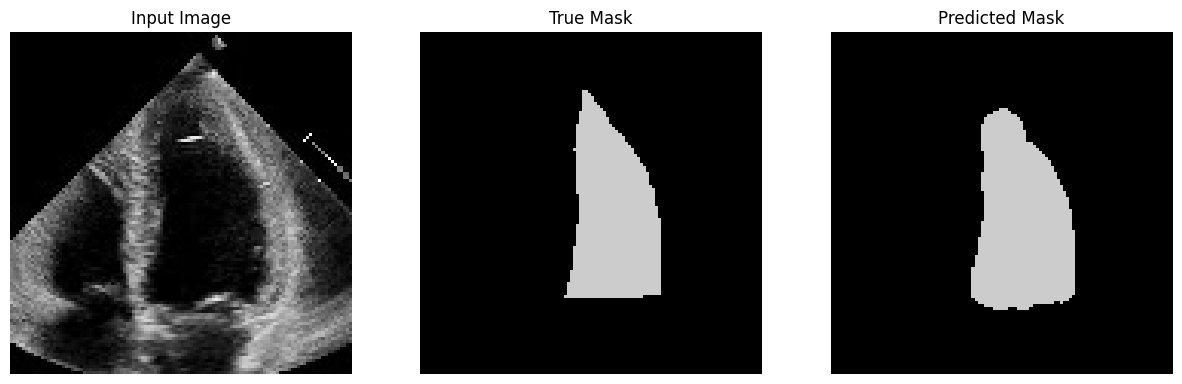

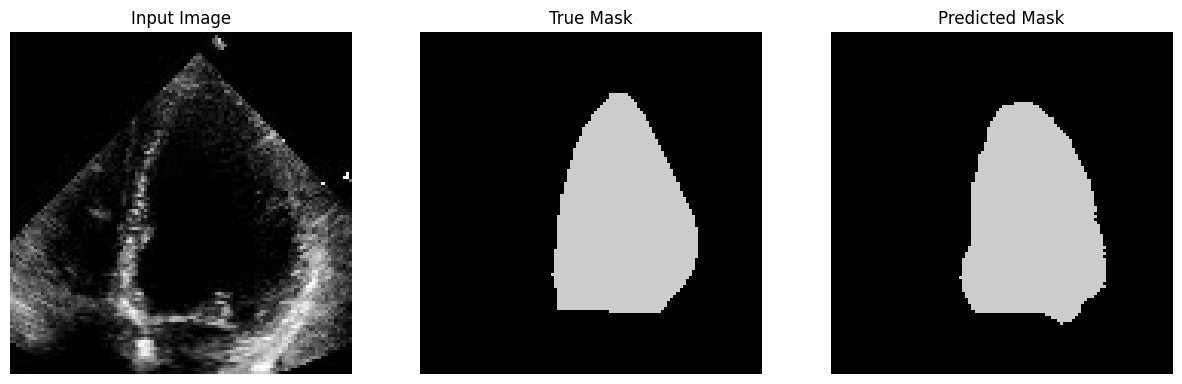

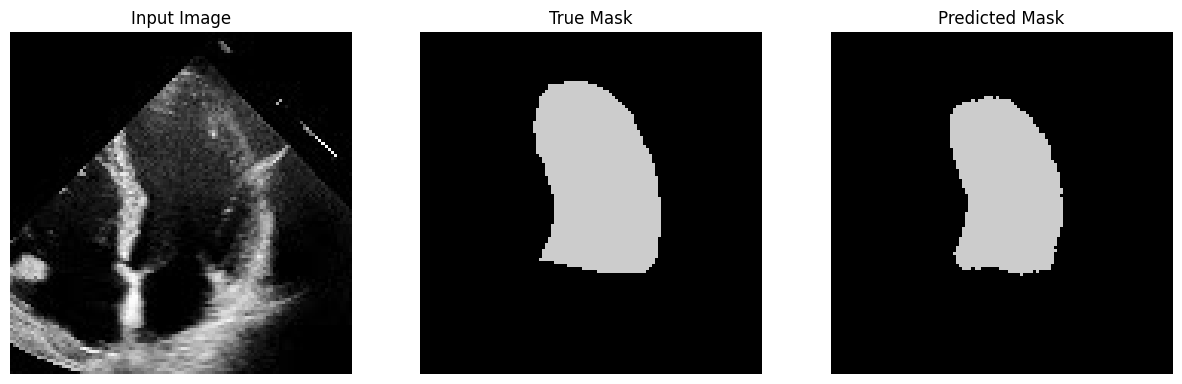

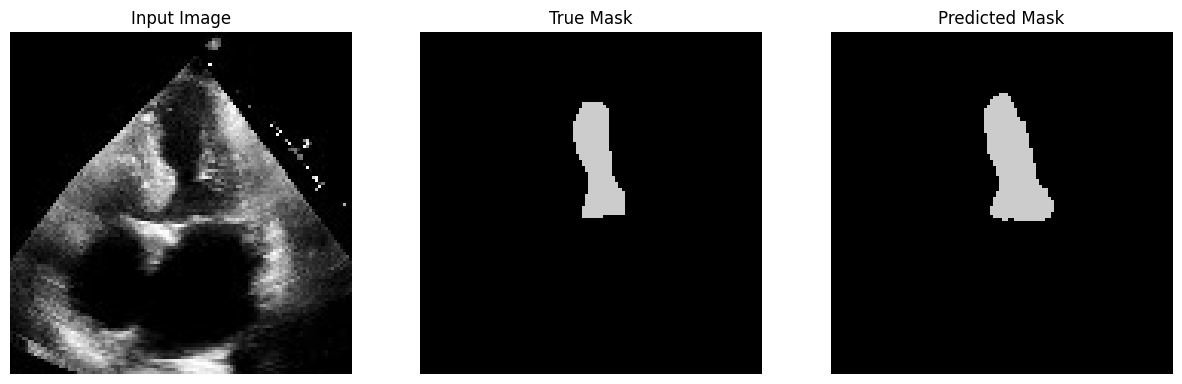

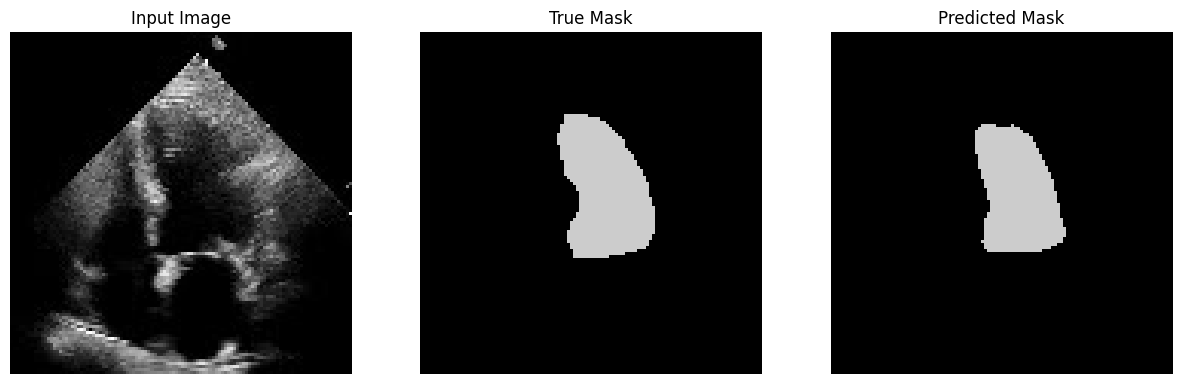

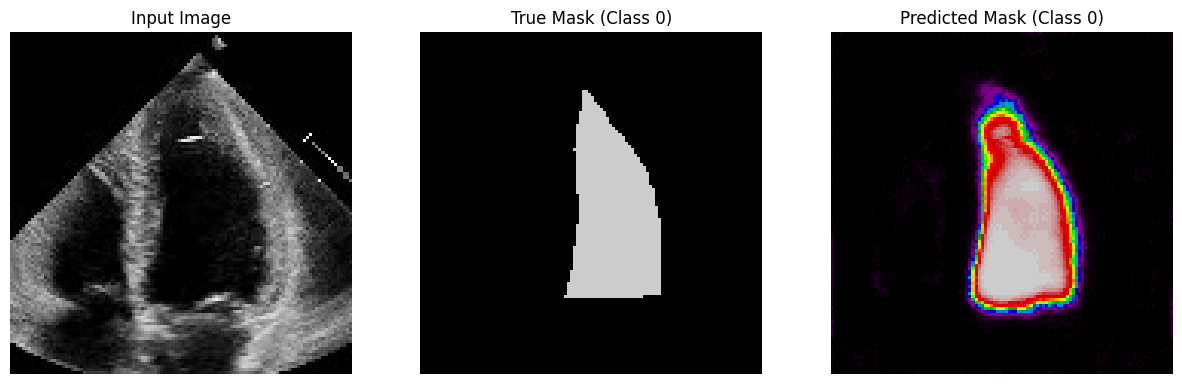

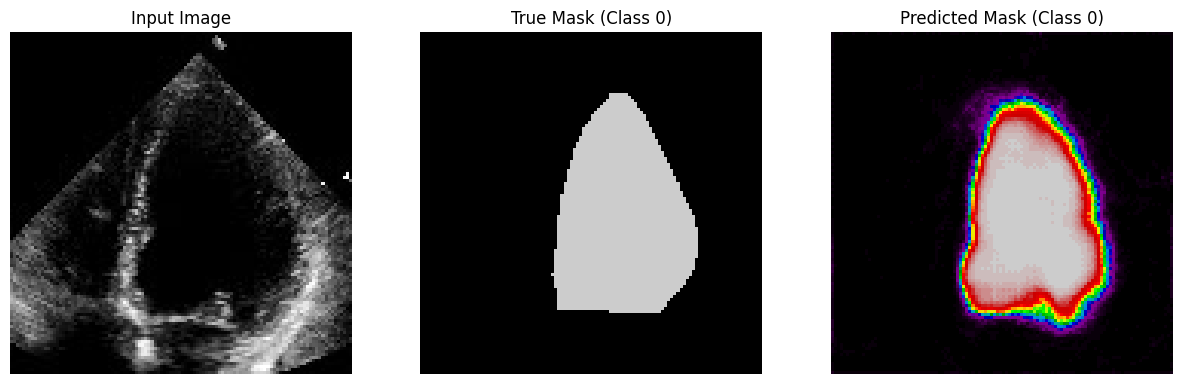

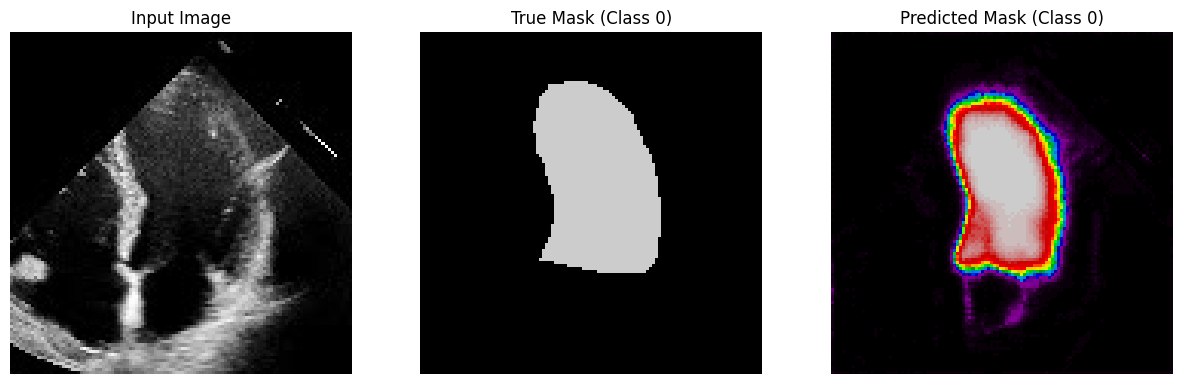

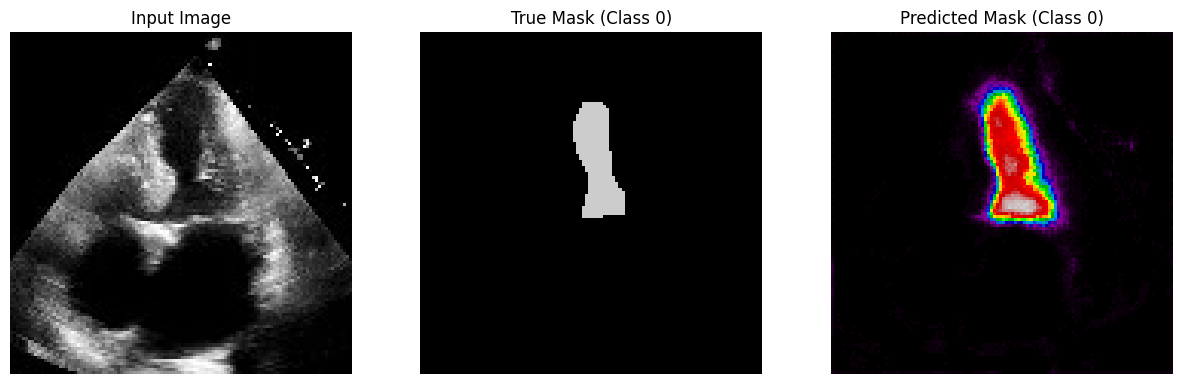

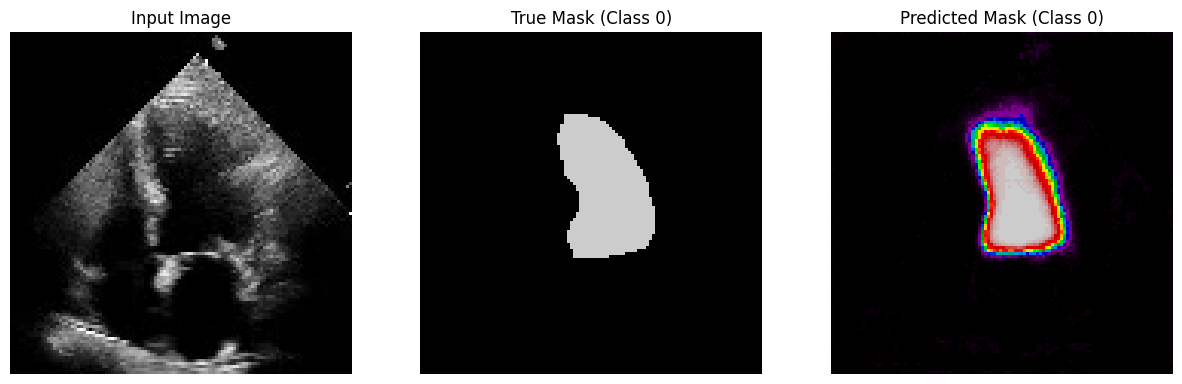

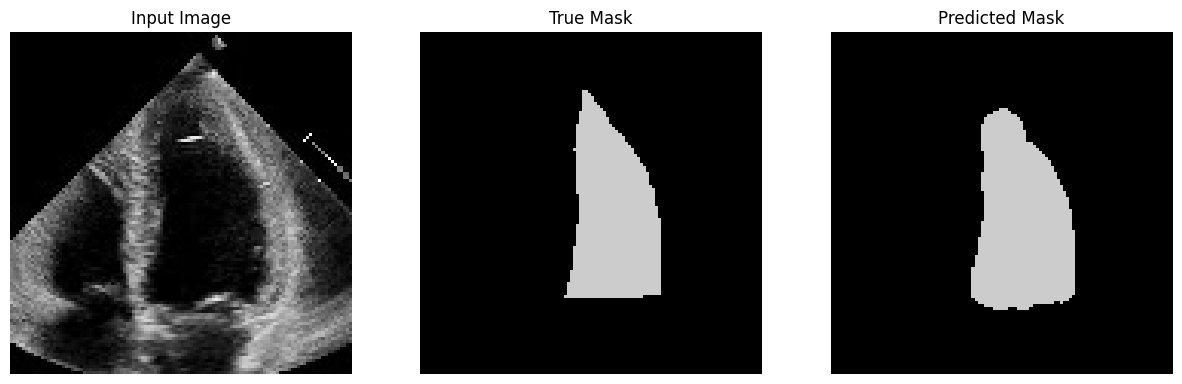

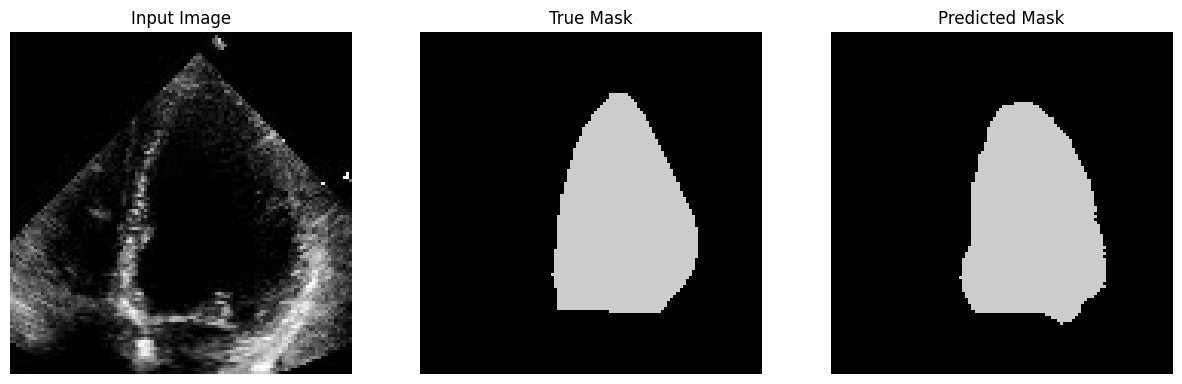

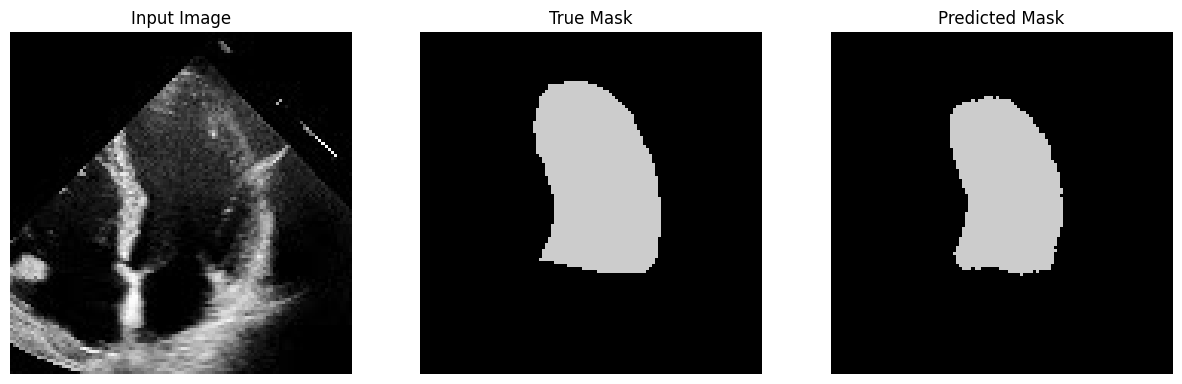

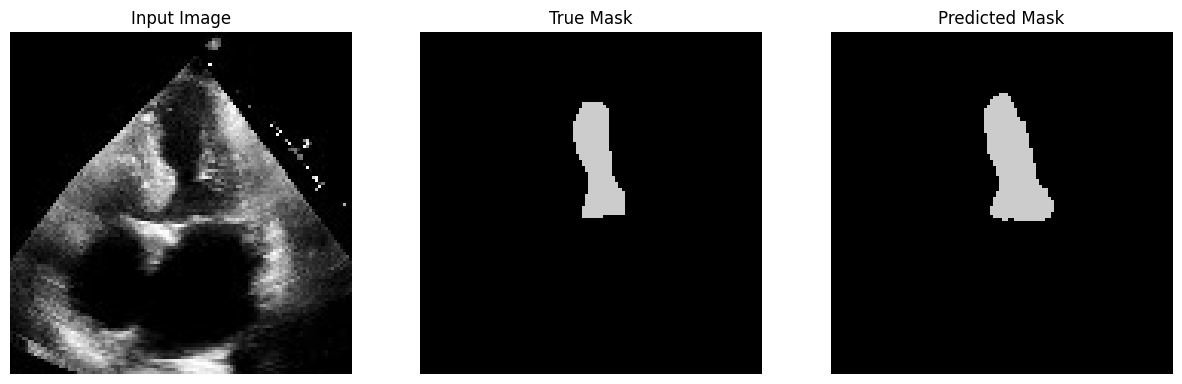

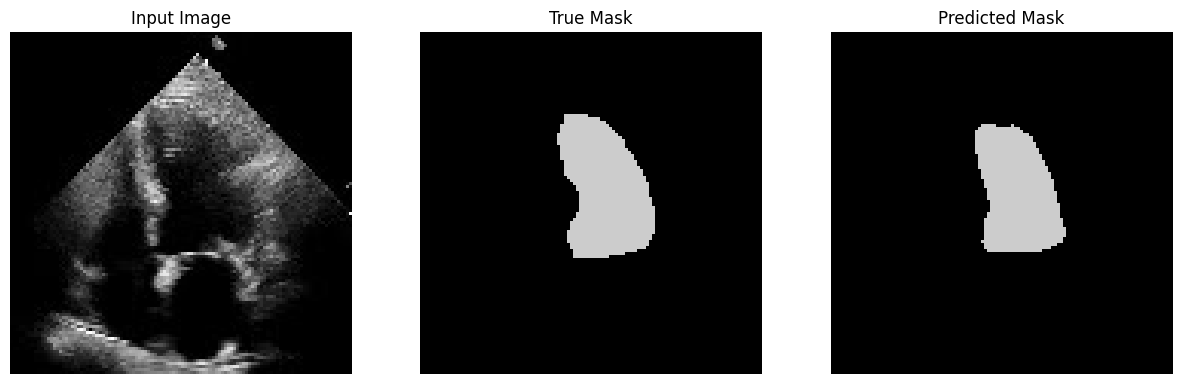

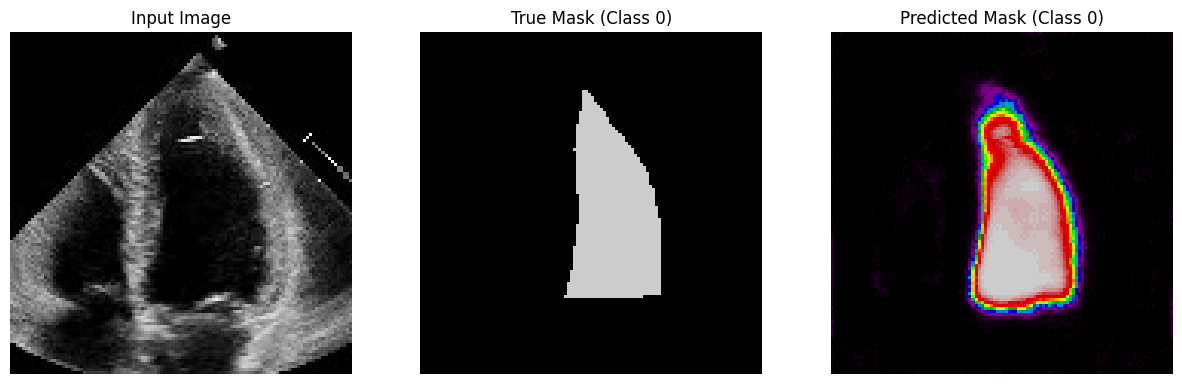

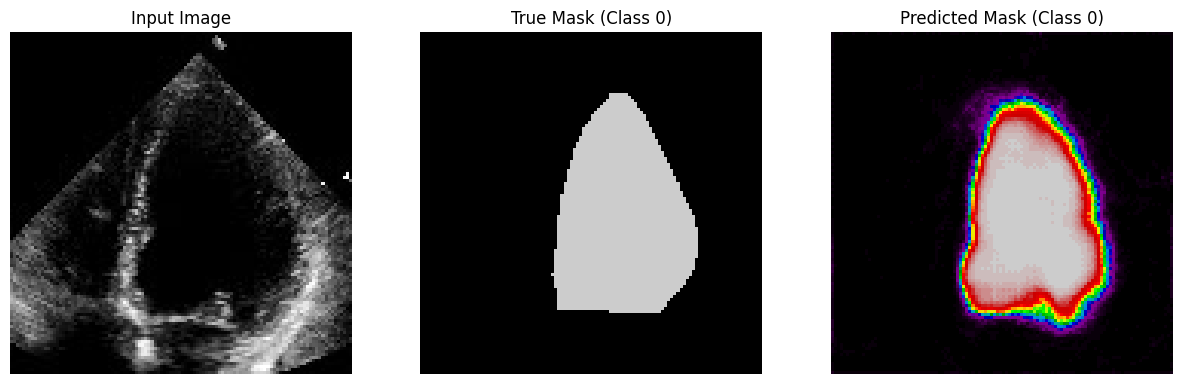

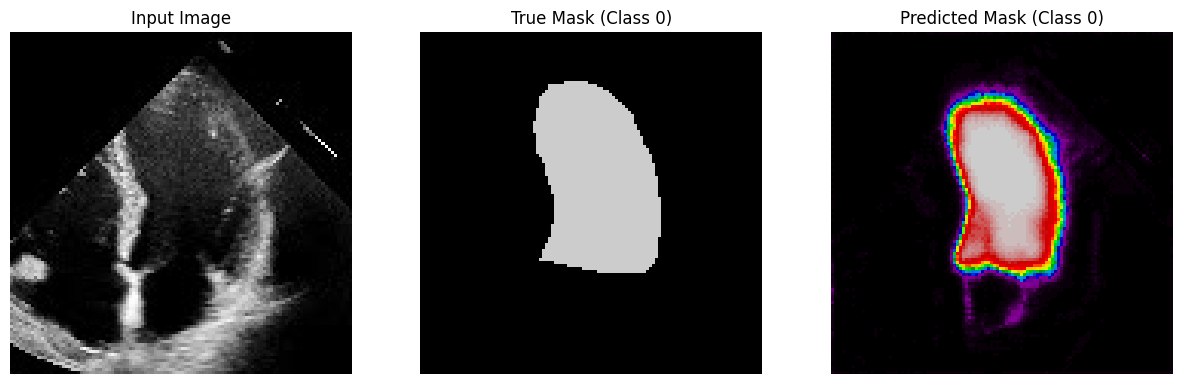

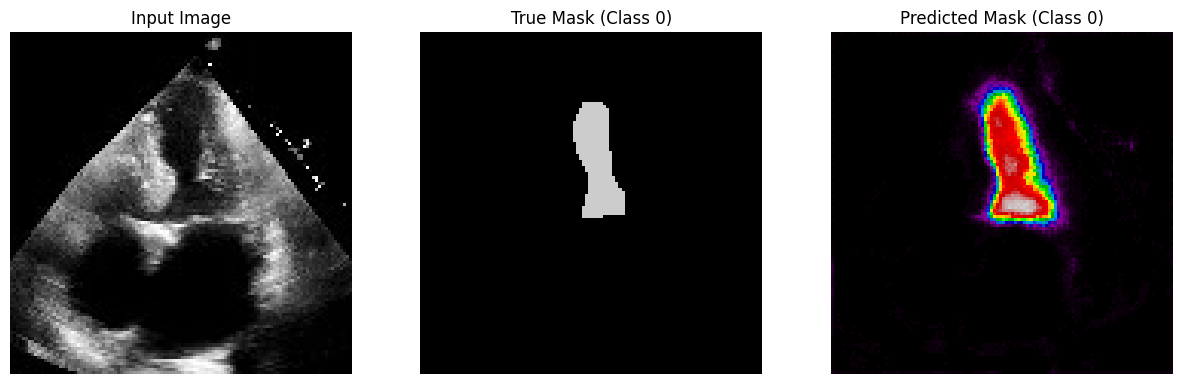

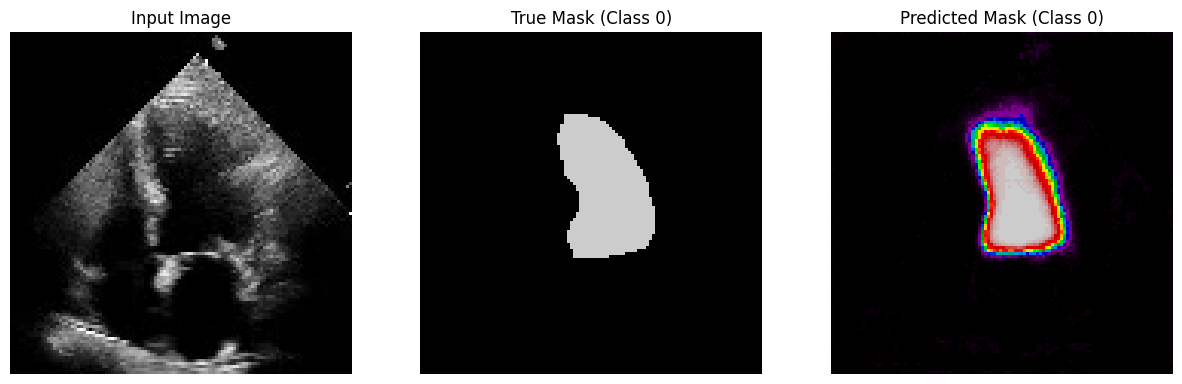

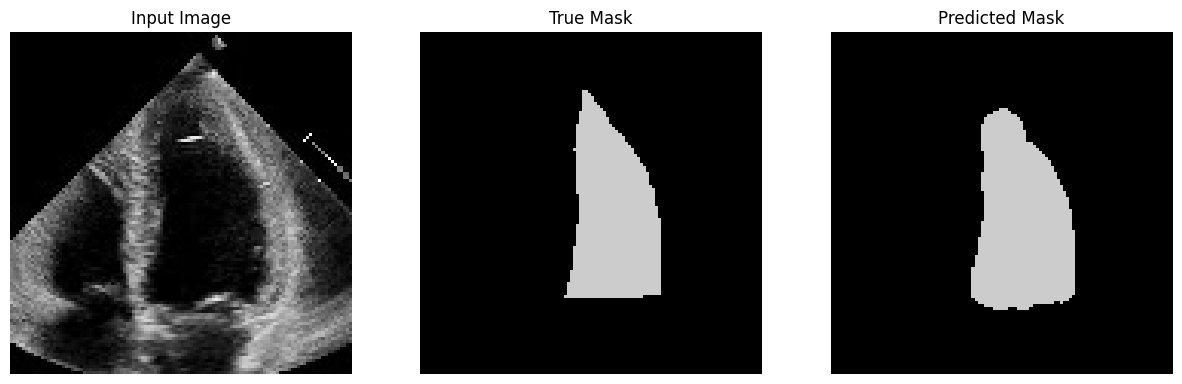

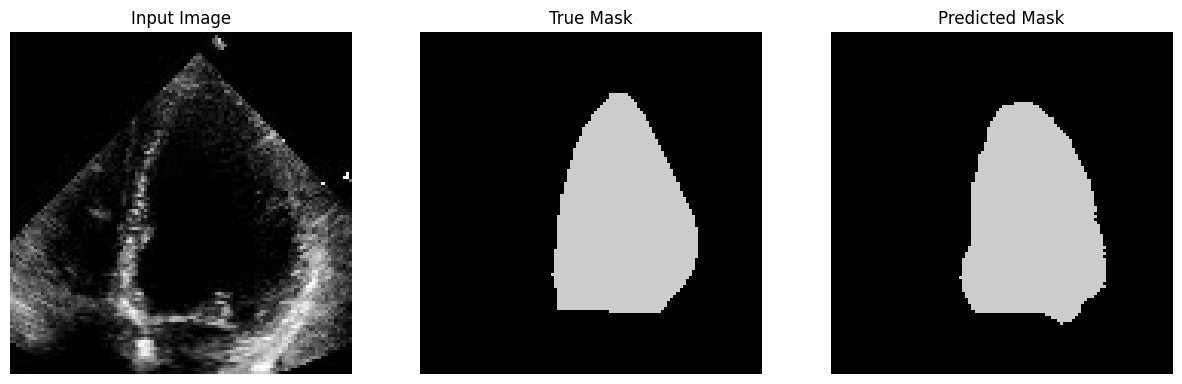

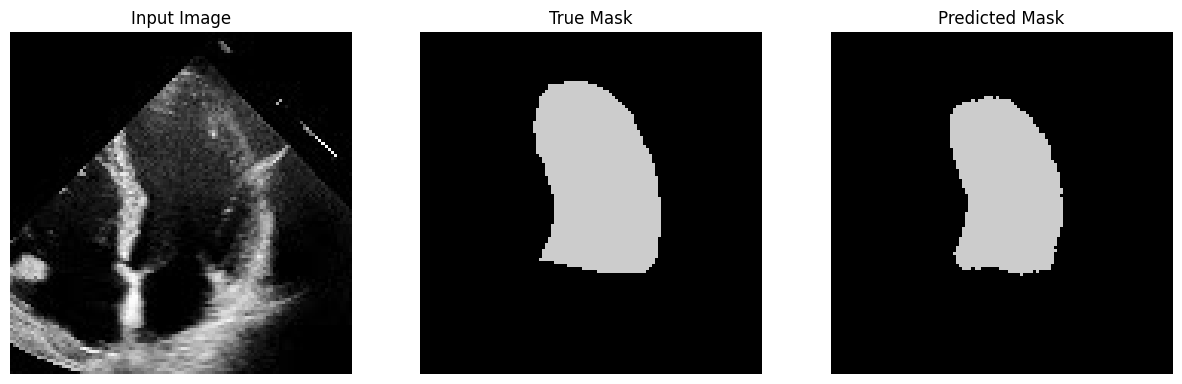

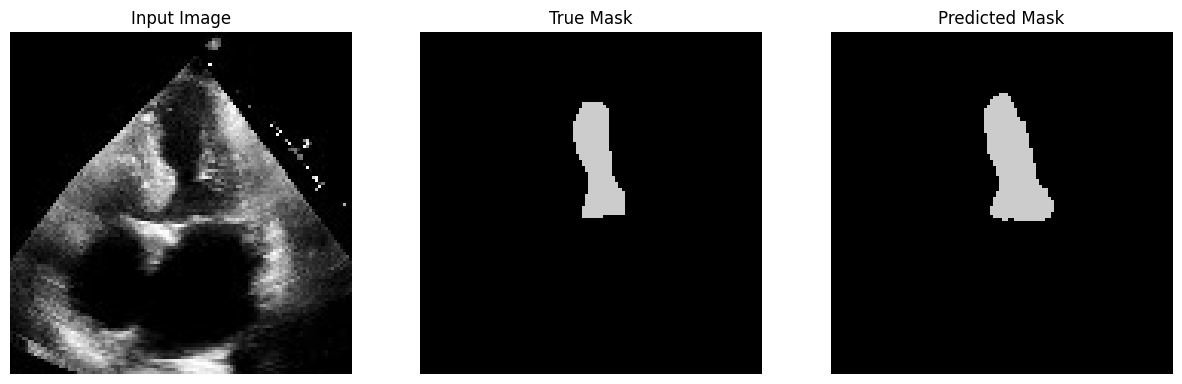

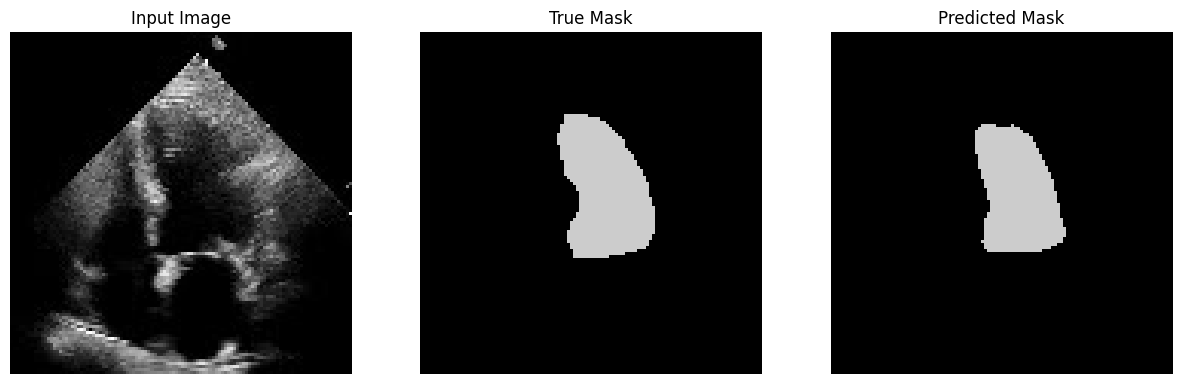

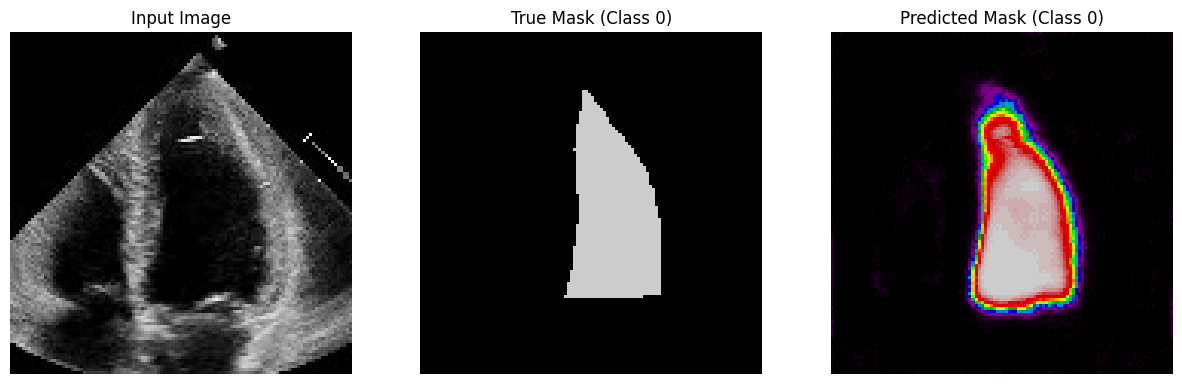

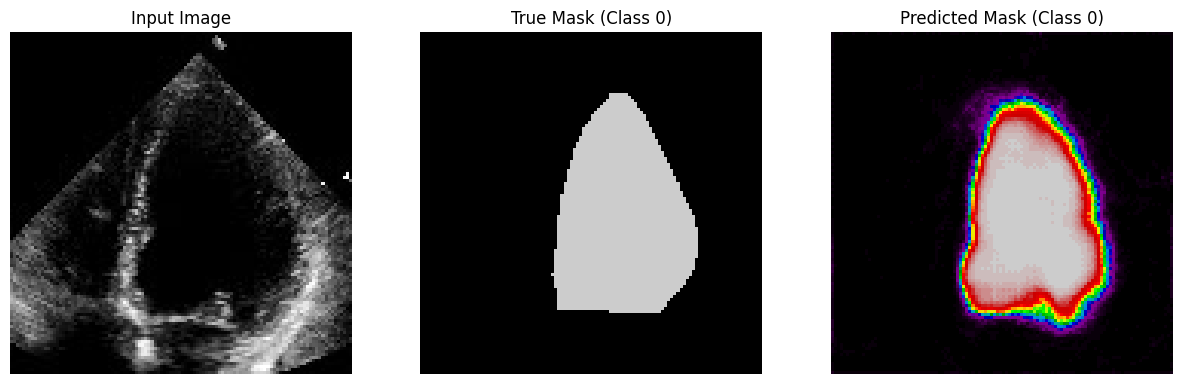

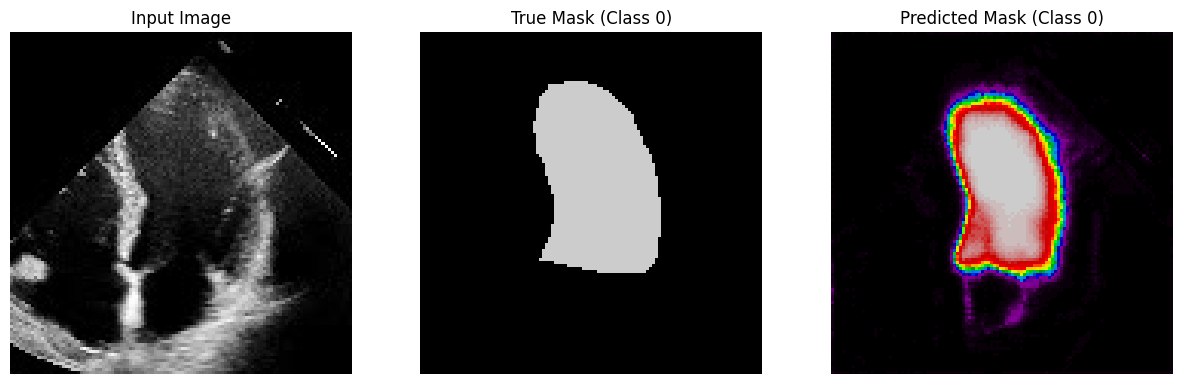

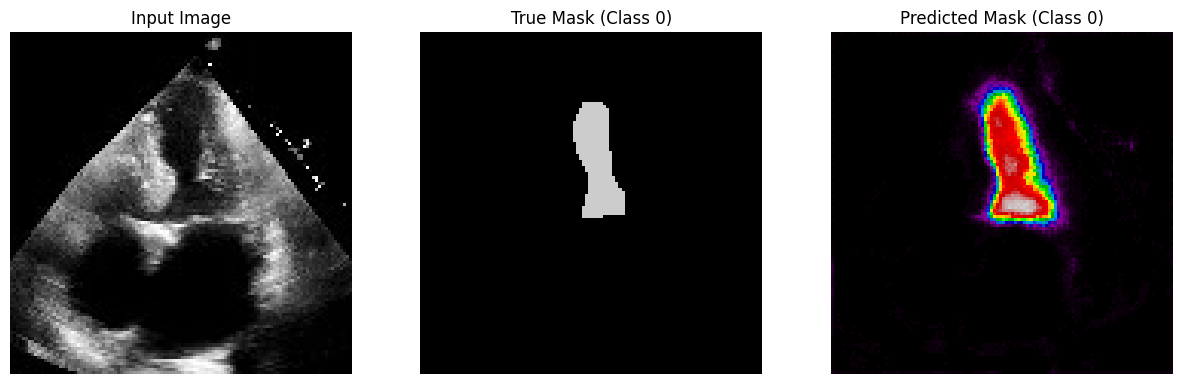

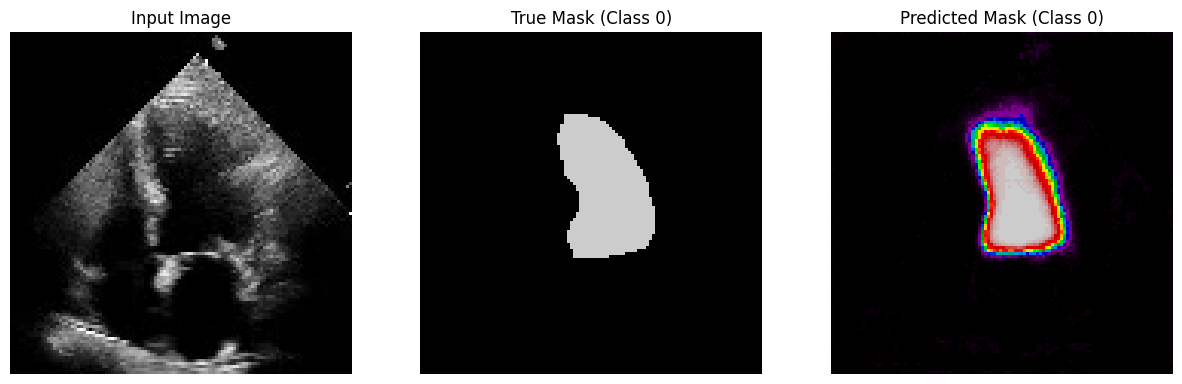

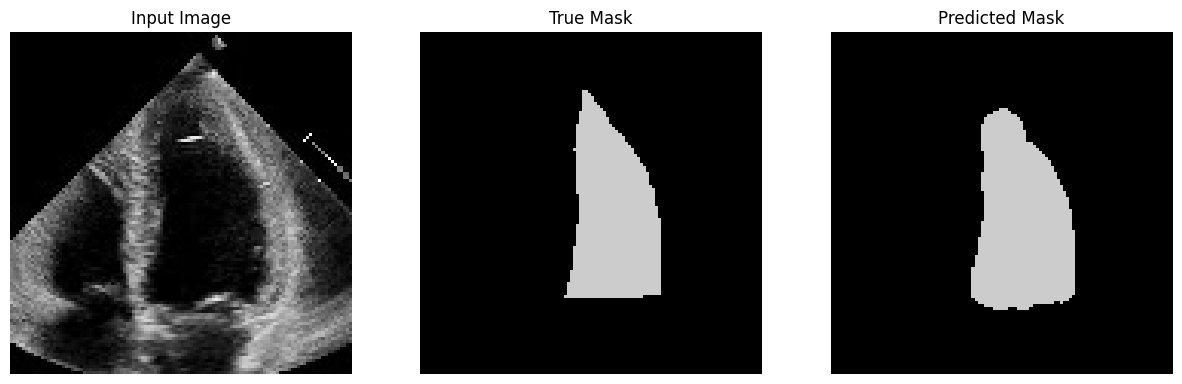

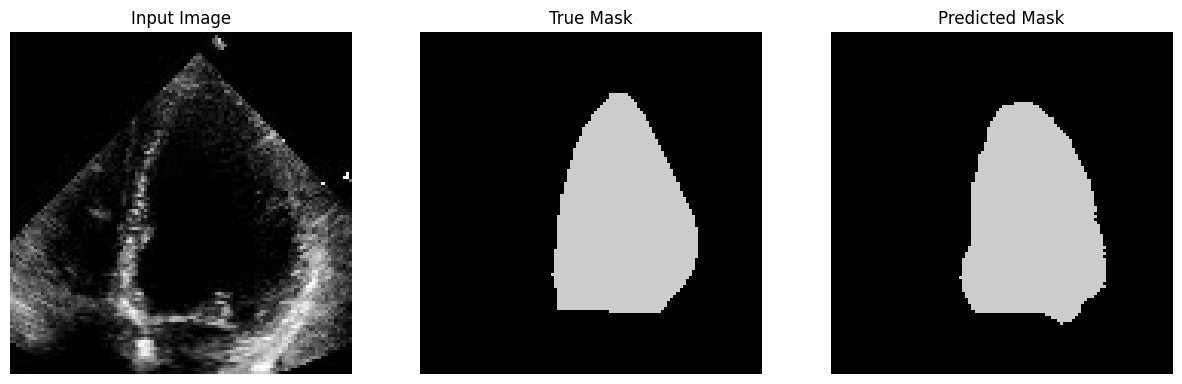

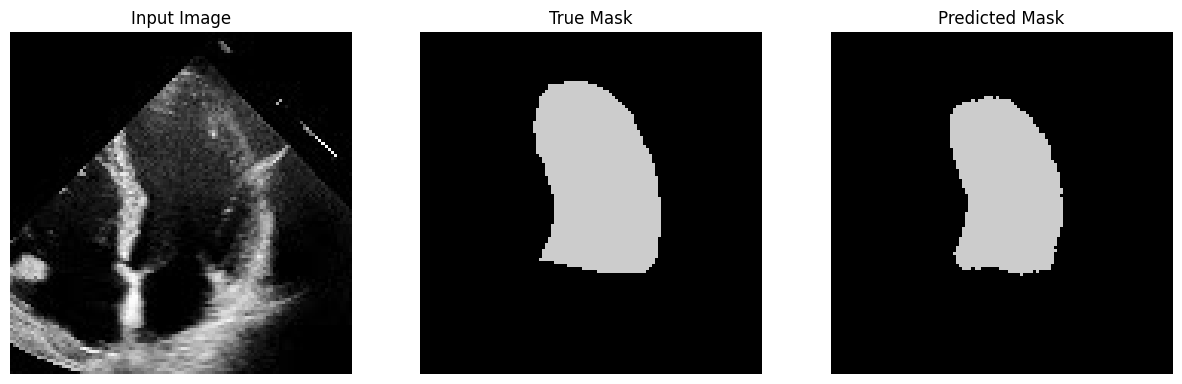

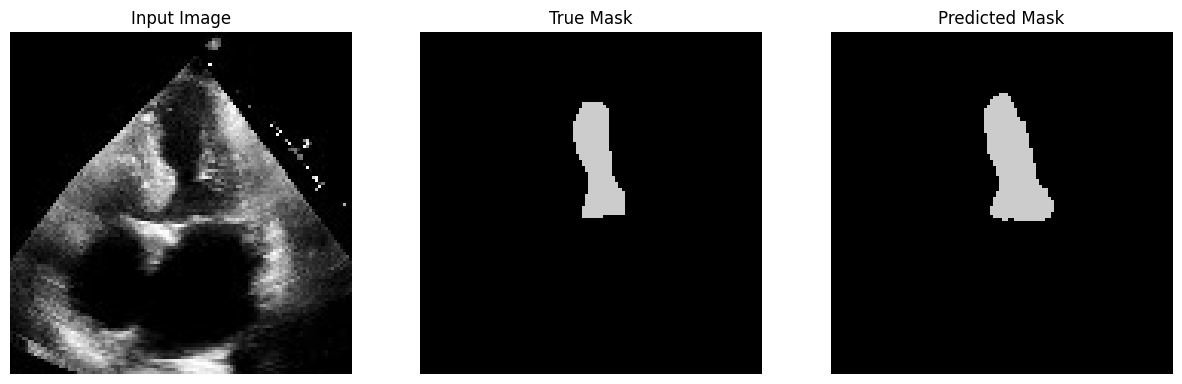

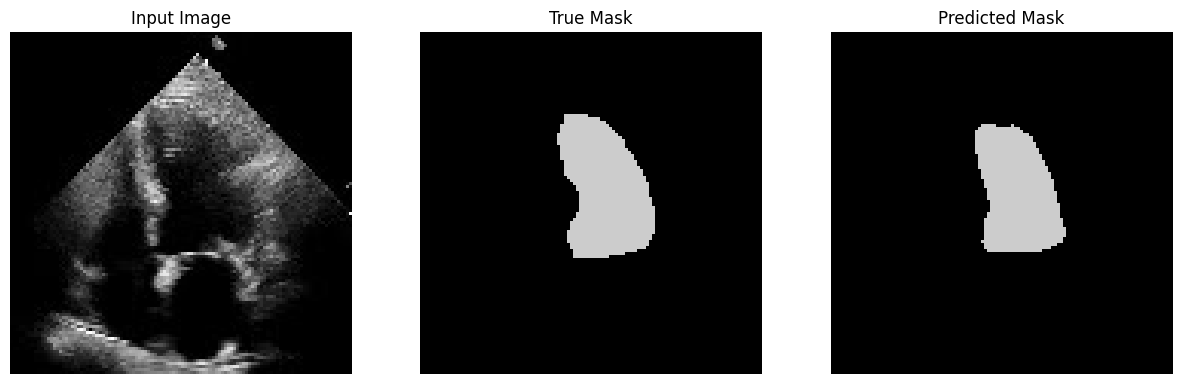

IOU: 0.8354, Dice: 0.9103


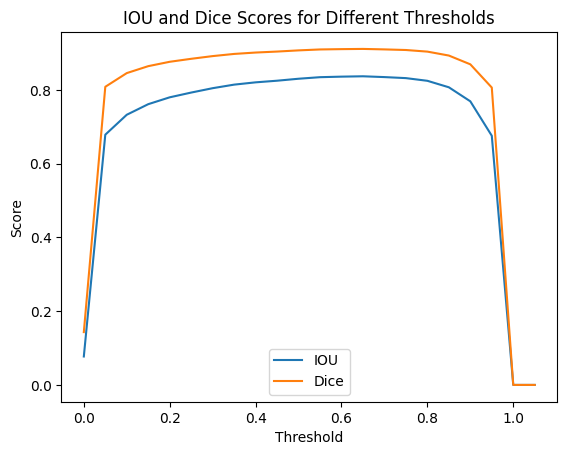

Best Threshold: 0.65
Best IOU: 0.8371155261993408
Best Dice: 0.9113368391990662


In [ ]:
''' 可視化結果 '''

# 只使用echonet資料完全水平翻轉訓練分割(使用左心室分割模擬右心室位置)

訓練集大小: 16038
驗證集大小: 2005
測試集大小: 2005
DataLoader 建立完成
No pretrained weights found for LV HorizontalFlip. Training from scratch.


Epoch 1/100: 100%|██████████| 251/251 [15:25<00:00,  3.69s/it]


Epoch 1: Train Loss: 0.5952, Val Loss: 0.4625
iou_per_class [0.022879010066390038] dice_per_class [0.04473453760147095]
iou_per_class [0.02382398582994938] dice_per_class [0.046539220958948135]
iou_per_class [0.023783570155501366] dice_per_class [0.046462107449769974]


Epoch 2/100: 100%|██████████| 251/251 [08:53<00:00,  2.13s/it]


Epoch 2: Train Loss: 0.4060, Val Loss: 0.3633
iou_per_class [0.0016527101397514343] dice_per_class [0.0032999664545059204]
iou_per_class [0.0021453576628118753] dice_per_class [0.004281529691070318]
iou_per_class [0.002047487534582615] dice_per_class [0.004086607601493597]


Epoch 3/100: 100%|██████████| 251/251 [08:56<00:00,  2.14s/it]


Epoch 3: Train Loss: 0.3430, Val Loss: 0.3239
iou_per_class [0.0005144707392901182] dice_per_class [0.001028412370942533]
iou_per_class [0.00059937231708318] dice_per_class [0.0011980265844613314]
iou_per_class [0.0005864444538019598] dice_per_class [0.0011722014751285315]


Epoch 4/100: 100%|██████████| 251/251 [09:04<00:00,  2.17s/it]


Epoch 4: Train Loss: 0.3154, Val Loss: 0.3049
iou_per_class [0.00015648701810277998] dice_per_class [0.0003129250544589013]
iou_per_class [0.0002626415516715497] dice_per_class [0.0005251452093943954]
iou_per_class [0.00025015059509314597] dice_per_class [0.0005001761019229889]


Epoch 5/100: 100%|██████████| 251/251 [08:50<00:00,  2.11s/it]


Epoch 5: Train Loss: 0.3010, Val Loss: 0.2942
iou_per_class [0.0001035084278555587] dice_per_class [0.00020699543529190123]
iou_per_class [0.00018544560589361936] dice_per_class [0.00037082243943586946]
iou_per_class [0.00015574971621390432] dice_per_class [0.00031145091634243727]


Epoch 6/100: 100%|██████████| 251/251 [08:52<00:00,  2.12s/it]


Epoch 6: Train Loss: 0.2923, Val Loss: 0.2869
iou_per_class [7.321863813558593e-05] dice_per_class [0.0001464265660615638]
iou_per_class [0.0001287936174776405] dice_per_class [0.00025755405658856034]
iou_per_class [0.00010213878704234958] dice_per_class [0.00020425670663826168]


Epoch 7/100: 100%|██████████| 251/251 [08:53<00:00,  2.12s/it]


Epoch 7: Train Loss: 0.2863, Val Loss: 0.2819
iou_per_class [6.0595197282964364e-05] dice_per_class [0.00012118305312469602]
iou_per_class [0.00010303701856173575] dice_per_class [0.0002060528058791533]
iou_per_class [8.426707790931687e-05] dice_per_class [0.00016851996770128608]


Epoch 8/100: 100%|██████████| 251/251 [08:57<00:00,  2.14s/it]


Epoch 8: Train Loss: 0.2817, Val Loss: 0.2775
iou_per_class [0.00011361340875737369] dice_per_class [0.0002272010169690475]
iou_per_class [0.00016228036838583648] dice_per_class [0.00032450808794237673]
iou_per_class [0.0001327831414528191] dice_per_class [0.00026553100906312466]


Epoch 9/100: 100%|██████████| 251/251 [08:52<00:00,  2.12s/it]


Epoch 9: Train Loss: 0.2777, Val Loss: 0.2737
iou_per_class [0.00017925490101333708] dice_per_class [0.00035844556987285614]
iou_per_class [0.00020349233818706125] dice_per_class [0.0004069018759764731]
iou_per_class [0.00020172256336081773] dice_per_class [0.00040336375241167843]


Epoch 10/100: 100%|██████████| 251/251 [08:46<00:00,  2.10s/it]


Epoch 10: Train Loss: 0.2738, Val Loss: 0.2701
iou_per_class [0.000340812694048509] dice_per_class [0.0006813931977376342]
iou_per_class [0.000381212419597432] dice_per_class [0.000762134266551584]
iou_per_class [0.00036767052370123565] dice_per_class [0.0007350707892328501]


Epoch 11/100: 100%|██████████| 251/251 [09:03<00:00,  2.16s/it]


Epoch 11: Train Loss: 0.2700, Val Loss: 0.2662
iou_per_class [0.0004897357430309057] dice_per_class [0.0009789920877665281]
iou_per_class [0.0006026749615557492] dice_per_class [0.0012046239571645856]
iou_per_class [0.0005973822553642094] dice_per_class [0.0011940511176362634]


Epoch 12/100: 100%|██████████| 251/251 [08:57<00:00,  2.14s/it]


Epoch 12: Train Loss: 0.2657, Val Loss: 0.2617
iou_per_class [0.0006714391056448221] dice_per_class [0.0013419771566987038]
iou_per_class [0.0007725806208327413] dice_per_class [0.001543968333862722]
iou_per_class [0.0008576635736972094] dice_per_class [0.0017138572875410318]


Epoch 13/100: 100%|██████████| 251/251 [08:56<00:00,  2.14s/it]


Epoch 13: Train Loss: 0.2611, Val Loss: 0.2569
iou_per_class [0.0009010828216560185] dice_per_class [0.001800543162971735]
iou_per_class [0.0010068186093121767] dice_per_class [0.0020116118248552084]
iou_per_class [0.0011255168356001377] dice_per_class [0.002248502802103758]


Epoch 14/100: 100%|██████████| 251/251 [10:42<00:00,  2.56s/it]


Epoch 14: Train Loss: 0.2559, Val Loss: 0.2511
iou_per_class [0.0011130236089229584] dice_per_class [0.0022235724609345198]
iou_per_class [0.0012539072195068002] dice_per_class [0.0025046737864613533]
iou_per_class [0.0014214369002729654] dice_per_class [0.0028388386126607656]


Epoch 15/100: 100%|██████████| 251/251 [11:44<00:00,  2.81s/it]


Epoch 15: Train Loss: 0.2498, Val Loss: 0.2456
iou_per_class [0.001390501158311963] dice_per_class [0.0027771408203989267]
iou_per_class [0.0015498207649216056] dice_per_class [0.0030948452185839415]
iou_per_class [0.0018013926455751061] dice_per_class [0.003596307011321187]


Epoch 16/100: 100%|██████████| 251/251 [11:38<00:00,  2.78s/it]


Epoch 16: Train Loss: 0.2430, Val Loss: 0.2384
iou_per_class [0.0017361198551952839] dice_per_class [0.00346622196957469]
iou_per_class [0.0019203394185751677] dice_per_class [0.003833317430689931]
iou_per_class [0.002150746062397957] dice_per_class [0.004292260855436325]


Epoch 17/100: 100%|██████████| 251/251 [09:16<00:00,  2.22s/it]


Epoch 17: Train Loss: 0.2358, Val Loss: 0.2310
iou_per_class [0.0023311376571655273] dice_per_class [0.004651431925594807]
iou_per_class [0.002611926756799221] dice_per_class [0.005210245028138161]
iou_per_class [0.0028641894459724426] dice_per_class [0.0057120188139379025]


Epoch 18/100: 100%|██████████| 251/251 [09:15<00:00,  2.21s/it]


Epoch 18: Train Loss: 0.2283, Val Loss: 0.2227
iou_per_class [0.0033492641523480415] dice_per_class [0.00667616818100214]
iou_per_class [0.0036578120198100805] dice_per_class [0.007288962136954069]
iou_per_class [0.003997063264250755] dice_per_class [0.00796230137348175]


Epoch 19/100: 100%|██████████| 251/251 [09:14<00:00,  2.21s/it]


Epoch 19: Train Loss: 0.2202, Val Loss: 0.2149
iou_per_class [0.004983061924576759] dice_per_class [0.009916708804666996]
iou_per_class [0.0057340688072144985] dice_per_class [0.011402753181755543]
iou_per_class [0.005956307053565979] dice_per_class [0.011842078529298306]


Epoch 20/100: 100%|██████████| 251/251 [09:25<00:00,  2.25s/it]


Epoch 20: Train Loss: 0.2109, Val Loss: 0.2049
iou_per_class [0.008772570639848709] dice_per_class [0.017392562702298164]
iou_per_class [0.01079777255654335] dice_per_class [0.021364852786064148]
iou_per_class [0.010435251519083977] dice_per_class [0.020654963329434395]


Epoch 21/100: 100%|██████████| 251/251 [09:07<00:00,  2.18s/it]


Epoch 21: Train Loss: 0.1997, Val Loss: 0.1919
iou_per_class [0.04540633410215378] dice_per_class [0.0868682935833931]
iou_per_class [0.059234172105789185] dice_per_class [0.11184339225292206]
iou_per_class [0.05034220963716507] dice_per_class [0.09585867822170258]


Epoch 22/100: 100%|██████████| 251/251 [09:11<00:00,  2.20s/it]


Epoch 22: Train Loss: 0.1856, Val Loss: 0.1770
iou_per_class [0.28687798976898193] dice_per_class [0.4458511173725128]
iou_per_class [0.33924850821495056] dice_per_class [0.5066251754760742]
iou_per_class [0.3012113571166992] dice_per_class [0.46297067403793335]


Epoch 23/100: 100%|██████████| 251/251 [09:01<00:00,  2.16s/it]


Epoch 23: Train Loss: 0.1682, Val Loss: 0.1579
iou_per_class [0.47117888927459717] dice_per_class [0.6405460238456726]
iou_per_class [0.5100929141044617] dice_per_class [0.6755781769752502]
iou_per_class [0.47119981050491333] dice_per_class [0.6405653357505798]


Epoch 24/100: 100%|██████████| 251/251 [09:10<00:00,  2.19s/it]


Epoch 24: Train Loss: 0.1491, Val Loss: 0.1398
iou_per_class [0.5856510996818542] dice_per_class [0.7386884689331055]
iou_per_class [0.6104345321655273] dice_per_class [0.7580991983413696]
iou_per_class [0.5773583054542542] dice_per_class [0.7320572733879089]


Epoch 25/100: 100%|██████████| 251/251 [09:06<00:00,  2.18s/it]


Epoch 25: Train Loss: 0.1323, Val Loss: 0.1243
iou_per_class [0.6456378102302551] dice_per_class [0.7846657037734985]
iou_per_class [0.6551517844200134] dice_per_class [0.7916516065597534]
iou_per_class [0.6321245431900024] dice_per_class [0.7746033072471619]


Epoch 26/100: 100%|██████████| 251/251 [09:11<00:00,  2.20s/it]


Epoch 26: Train Loss: 0.1190, Val Loss: 0.1131
iou_per_class [0.6872390508651733] dice_per_class [0.8146315217018127]
iou_per_class [0.6919571757316589] dice_per_class [0.8179369568824768]
iou_per_class [0.6755949258804321] dice_per_class [0.806394100189209]


Epoch 27/100: 100%|██████████| 251/251 [09:28<00:00,  2.27s/it]


Epoch 27: Train Loss: 0.1086, Val Loss: 0.1039
iou_per_class [0.7198421955108643] dice_per_class [0.8371026515960693]
iou_per_class [0.7184470891952515] dice_per_class [0.8361585140228271]
iou_per_class [0.7077345848083496] dice_per_class [0.8288578391075134]


Epoch 28/100: 100%|██████████| 251/251 [09:34<00:00,  2.29s/it]


Epoch 28: Train Loss: 0.1003, Val Loss: 0.0969
iou_per_class [0.7356172204017639] dice_per_class [0.847672164440155]
iou_per_class [0.7348794341087341] dice_per_class [0.8471821546554565]
iou_per_class [0.7274758815765381] dice_per_class [0.8422414064407349]


Epoch 29/100: 100%|██████████| 251/251 [09:35<00:00,  2.29s/it]


Epoch 29: Train Loss: 0.0937, Val Loss: 0.0909
iou_per_class [0.7504966855049133] dice_per_class [0.8574671149253845]
iou_per_class [0.7463993430137634] dice_per_class [0.8547865748405457]
iou_per_class [0.7445414662361145] dice_per_class [0.8535669445991516]


Epoch 30/100: 100%|██████████| 251/251 [09:34<00:00,  2.29s/it]


Epoch 30: Train Loss: 0.0883, Val Loss: 0.0866
iou_per_class [0.7646350860595703] dice_per_class [0.866621196269989]
iou_per_class [0.7610177993774414] dice_per_class [0.864293098449707]
iou_per_class [0.763424813747406] dice_per_class [0.8658432960510254]


Epoch 31/100: 100%|██████████| 251/251 [09:23<00:00,  2.24s/it]


Epoch 31: Train Loss: 0.0840, Val Loss: 0.0828
iou_per_class [0.7749014496803284] dice_per_class [0.8731768727302551]
iou_per_class [0.7697969675064087] dice_per_class [0.8699268698692322]
iou_per_class [0.7739309072494507] dice_per_class [0.8725603818893433]


Epoch 32/100: 100%|██████████| 251/251 [09:23<00:00,  2.25s/it]


Epoch 32: Train Loss: 0.0803, Val Loss: 0.0790
iou_per_class [0.7796735167503357] dice_per_class [0.8761983513832092]
iou_per_class [0.7748148441314697] dice_per_class [0.8731218576431274]
iou_per_class [0.7807255387306213] dice_per_class [0.8768622875213623]


Epoch 33/100: 100%|██████████| 251/251 [09:18<00:00,  2.22s/it]


Epoch 33: Train Loss: 0.0771, Val Loss: 0.0762
iou_per_class [0.7830811142921448] dice_per_class [0.8783460259437561]
iou_per_class [0.7782845497131348] dice_per_class [0.8753206133842468]
iou_per_class [0.784921407699585] dice_per_class [0.8795024752616882]


Epoch 34/100: 100%|██████████| 251/251 [09:26<00:00,  2.26s/it]


Epoch 34: Train Loss: 0.0745, Val Loss: 0.0739
iou_per_class [0.7905164361000061] dice_per_class [0.883003830909729]
iou_per_class [0.7858891487121582] dice_per_class [0.8801096677780151]
iou_per_class [0.7927126288414001] dice_per_class [0.8843722343444824]


Epoch 35/100: 100%|██████████| 251/251 [09:03<00:00,  2.16s/it]


Epoch 35: Train Loss: 0.0721, Val Loss: 0.0715
iou_per_class [0.7967501878738403] dice_per_class [0.8868792057037354]
iou_per_class [0.7916322946548462] dice_per_class [0.8836995363235474]
iou_per_class [0.7983514666557312] dice_per_class [0.8878703713417053]


Epoch 36/100: 100%|██████████| 251/251 [07:33<00:00,  1.81s/it]


Epoch 36: Train Loss: 0.0701, Val Loss: 0.0697
iou_per_class [0.7975018620491028] dice_per_class [0.8873447179794312]
iou_per_class [0.7914022207260132] dice_per_class [0.8835561871528625]
iou_per_class [0.7983385324478149] dice_per_class [0.8878623247146606]


Epoch 37/100: 100%|██████████| 251/251 [08:53<00:00,  2.12s/it]


Epoch 37: Train Loss: 0.0683, Val Loss: 0.0682
iou_per_class [0.8062235713005066] dice_per_class [0.8927173614501953]
iou_per_class [0.7979600429534912] dice_per_class [0.8876282572746277]
iou_per_class [0.8049852252006531] dice_per_class [0.891957700252533]


Epoch 38/100: 100%|██████████| 251/251 [10:52<00:00,  2.60s/it]


Epoch 38: Train Loss: 0.0666, Val Loss: 0.0671
iou_per_class [0.8018856048583984] dice_per_class [0.8900516629219055]
iou_per_class [0.795040488243103] dice_per_class [0.8858190178871155]
iou_per_class [0.8009140491485596] dice_per_class [0.8894528150558472]


Epoch 39/100: 100%|██████████| 251/251 [10:49<00:00,  2.59s/it]


Epoch 39: Train Loss: 0.0651, Val Loss: 0.0653
iou_per_class [0.810115396976471] dice_per_class [0.895098090171814]
iou_per_class [0.8030849099159241] dice_per_class [0.8907898664474487]
iou_per_class [0.8110487461090088] dice_per_class [0.8956674933433533]


Epoch 40/100: 100%|██████████| 251/251 [10:47<00:00,  2.58s/it]


Epoch 40: Train Loss: 0.0638, Val Loss: 0.0640
iou_per_class [0.8143935203552246] dice_per_class [0.8977032899856567]
iou_per_class [0.8060459494590759] dice_per_class [0.8926084637641907]
iou_per_class [0.8121354579925537] dice_per_class [0.8963297605514526]


Epoch 41/100: 100%|██████████| 251/251 [10:43<00:00,  2.56s/it]


Epoch 41: Train Loss: 0.0626, Val Loss: 0.0630
iou_per_class [0.816220223903656] dice_per_class [0.898811936378479]
iou_per_class [0.808157742023468] dice_per_class [0.8939018249511719]
iou_per_class [0.813849687576294] dice_per_class [0.897372841835022]


Epoch 42/100: 100%|██████████| 251/251 [10:48<00:00,  2.59s/it]


Epoch 42: Train Loss: 0.0615, Val Loss: 0.0621
iou_per_class [0.8140774369239807] dice_per_class [0.8975112438201904]
iou_per_class [0.8058833479881287] dice_per_class [0.8925087451934814]
iou_per_class [0.8137025237083435] dice_per_class [0.8972833156585693]


Epoch 43/100: 100%|██████████| 251/251 [11:02<00:00,  2.64s/it]


Epoch 43: Train Loss: 0.0605, Val Loss: 0.0610
iou_per_class [0.8163135051727295] dice_per_class [0.8988685011863708]
iou_per_class [0.807414174079895] dice_per_class [0.8934467434883118]
iou_per_class [0.8132204413414001] dice_per_class [0.8969901204109192]


Epoch 44/100: 100%|██████████| 251/251 [10:56<00:00,  2.61s/it]


Epoch 44: Train Loss: 0.0595, Val Loss: 0.0601
iou_per_class [0.8176422119140625] dice_per_class [0.8996734619140625]
iou_per_class [0.8121329545974731] dice_per_class [0.8963282108306885]
iou_per_class [0.8180566430091858] dice_per_class [0.8999242782592773]


Epoch 45/100: 100%|██████████| 251/251 [11:04<00:00,  2.65s/it]


Epoch 45: Train Loss: 0.0586, Val Loss: 0.0593
iou_per_class [0.821277379989624] dice_per_class [0.9018696546554565]
iou_per_class [0.8137596845626831] dice_per_class [0.8973180651664734]
iou_per_class [0.8174482583999634] dice_per_class [0.899556040763855]


Epoch 46/100: 100%|██████████| 251/251 [10:50<00:00,  2.59s/it]


Epoch 46: Train Loss: 0.0578, Val Loss: 0.0585
iou_per_class [0.8219437599182129] dice_per_class [0.9022712707519531]
iou_per_class [0.8140032291412354] dice_per_class [0.8974661231040955]
iou_per_class [0.8189175724983215] dice_per_class [0.9004449844360352]


Epoch 47/100: 100%|██████████| 251/251 [11:00<00:00,  2.63s/it]


Epoch 47: Train Loss: 0.0570, Val Loss: 0.0578
iou_per_class [0.8227144479751587] dice_per_class [0.9027354121208191]
iou_per_class [0.8163809180259705] dice_per_class [0.8989093899726868]
iou_per_class [0.821124255657196] dice_per_class [0.9017772674560547]


Epoch 48/100: 100%|██████████| 251/251 [10:53<00:00,  2.60s/it]


Epoch 48: Train Loss: 0.0563, Val Loss: 0.0572
iou_per_class [0.8257743120193481] dice_per_class [0.9045743346214294]
iou_per_class [0.8173508048057556] dice_per_class [0.8994969725608826]
iou_per_class [0.8211187124252319] dice_per_class [0.9017739295959473]


Epoch 49/100: 100%|██████████| 251/251 [10:57<00:00,  2.62s/it]


Epoch 49: Train Loss: 0.0555, Val Loss: 0.0565
iou_per_class [0.8256269693374634] dice_per_class [0.9044859409332275]
iou_per_class [0.8167257308959961] dice_per_class [0.8991183638572693]
iou_per_class [0.8220174908638] dice_per_class [0.9023157358169556]


Epoch 50/100: 100%|██████████| 251/251 [10:52<00:00,  2.60s/it]


Epoch 50: Train Loss: 0.0550, Val Loss: 0.0559
iou_per_class [0.8244621753692627] dice_per_class [0.9037865400314331]
iou_per_class [0.8158572912216187] dice_per_class [0.8985918760299683]
iou_per_class [0.8216896057128906] dice_per_class [0.9021180868148804]


Epoch 51/100: 100%|██████████| 251/251 [10:56<00:00,  2.61s/it]


Epoch 51: Train Loss: 0.0543, Val Loss: 0.0554
iou_per_class [0.8272742629051208] dice_per_class [0.9054735898971558]
iou_per_class [0.818968653678894] dice_per_class [0.900475800037384]
iou_per_class [0.8219161033630371] dice_per_class [0.902254581451416]


Epoch 52/100: 100%|██████████| 251/251 [10:56<00:00,  2.62s/it]


Epoch 52: Train Loss: 0.0537, Val Loss: 0.0551
iou_per_class [0.827751636505127] dice_per_class [0.9057593941688538]
iou_per_class [0.8219566941261292] dice_per_class [0.9022790789604187]
iou_per_class [0.8250132203102112] dice_per_class [0.9041175246238708]


Epoch 53/100: 100%|██████████| 251/251 [10:55<00:00,  2.61s/it]


Epoch 53: Train Loss: 0.0531, Val Loss: 0.0547
iou_per_class [0.827104389667511] dice_per_class [0.9053717851638794]
iou_per_class [0.8181395530700684] dice_per_class [0.8999744057655334]
iou_per_class [0.8243427872657776] dice_per_class [0.9037147760391235]


Epoch 54/100: 100%|██████████| 251/251 [10:48<00:00,  2.58s/it]


Epoch 54: Train Loss: 0.0526, Val Loss: 0.0539
iou_per_class [0.8289452195167542] dice_per_class [0.9064735770225525]
iou_per_class [0.8216150999069214] dice_per_class [0.9020732045173645]
iou_per_class [0.8249951601028442] dice_per_class [0.9041066765785217]


Epoch 55/100: 100%|██████████| 251/251 [10:52<00:00,  2.60s/it]


Epoch 55: Train Loss: 0.0521, Val Loss: 0.0535
iou_per_class [0.8308769464492798] dice_per_class [0.907627284526825]
iou_per_class [0.822645902633667] dice_per_class [0.9026941657066345]
iou_per_class [0.825411856174469] dice_per_class [0.904356837272644]


Epoch 56/100: 100%|██████████| 251/251 [10:55<00:00,  2.61s/it]


Epoch 56: Train Loss: 0.0516, Val Loss: 0.0531
iou_per_class [0.8275550007820129] dice_per_class [0.9056416749954224]
iou_per_class [0.8200211524963379] dice_per_class [0.9011116623878479]
iou_per_class [0.824580729007721] dice_per_class [0.9038577675819397]


Epoch 57/100: 100%|██████████| 251/251 [10:57<00:00,  2.62s/it]


Epoch 57: Train Loss: 0.0511, Val Loss: 0.0528
iou_per_class [0.83077472448349] dice_per_class [0.9075663089752197]
iou_per_class [0.8241523504257202] dice_per_class [0.9036003351211548]
iou_per_class [0.8281130194664001] dice_per_class [0.9059757590293884]


Epoch 58/100: 100%|██████████| 251/251 [11:06<00:00,  2.65s/it]


Epoch 58: Train Loss: 0.0507, Val Loss: 0.0523
iou_per_class [0.8308077454566956] dice_per_class [0.9075860381126404]
iou_per_class [0.8232565522193909] dice_per_class [0.9030616879463196]
iou_per_class [0.8279522061347961] dice_per_class [0.9058794975280762]


Epoch 59/100: 100%|██████████| 251/251 [10:55<00:00,  2.61s/it]


Epoch 59: Train Loss: 0.0503, Val Loss: 0.0519
iou_per_class [0.831752598285675] dice_per_class [0.9081494808197021]
iou_per_class [0.8245570063591003] dice_per_class [0.9038435220718384]
iou_per_class [0.8277086615562439] dice_per_class [0.9057337045669556]


Epoch 60/100: 100%|██████████| 251/251 [10:56<00:00,  2.62s/it]


Epoch 60: Train Loss: 0.0499, Val Loss: 0.0518
iou_per_class [0.8281043767929077] dice_per_class [0.905970573425293]
iou_per_class [0.8235375881195068] dice_per_class [0.9032307267189026]
iou_per_class [0.8264155387878418] dice_per_class [0.904958963394165]


Epoch 61/100: 100%|██████████| 251/251 [10:56<00:00,  2.61s/it]


Epoch 61: Train Loss: 0.0495, Val Loss: 0.0513
iou_per_class [0.8293142318725586] dice_per_class [0.9066941142082214]
iou_per_class [0.8232648968696594] dice_per_class [0.9030666947364807]
iou_per_class [0.827272891998291] dice_per_class [0.9054727554321289]


Epoch 62/100: 100%|██████████| 251/251 [11:02<00:00,  2.64s/it]


Epoch 62: Train Loss: 0.0491, Val Loss: 0.0511
iou_per_class [0.8342241048812866] dice_per_class [0.9096207022666931]
iou_per_class [0.8267970085144043] dice_per_class [0.9051876068115234]
iou_per_class [0.8292877078056335] dice_per_class [0.9066782593727112]


Epoch 63/100: 100%|██████████| 251/251 [10:55<00:00,  2.61s/it]


Epoch 63: Train Loss: 0.0488, Val Loss: 0.0506
iou_per_class [0.8321704268455505] dice_per_class [0.9083985090255737]
iou_per_class [0.8254857063293457] dice_per_class [0.9044011831283569]
iou_per_class [0.8294473886489868] dice_per_class [0.9067736864089966]


Epoch 64/100: 100%|██████████| 251/251 [11:04<00:00,  2.65s/it]


Epoch 64: Train Loss: 0.0484, Val Loss: 0.0504
iou_per_class [0.8332154154777527] dice_per_class [0.909020721912384]
iou_per_class [0.8257974982261658] dice_per_class [0.9045882821083069]
iou_per_class [0.8294230103492737] dice_per_class [0.9067591428756714]


Epoch 65/100: 100%|██████████| 251/251 [07:43<00:00,  1.85s/it]


Epoch 65: Train Loss: 0.0480, Val Loss: 0.0501
iou_per_class [0.8350847959518433] dice_per_class [0.910132110118866]
iou_per_class [0.8281852602958679] dice_per_class [0.9060189723968506]
iou_per_class [0.8309001922607422] dice_per_class [0.9076411724090576]


Epoch 66/100: 100%|██████████| 251/251 [07:08<00:00,  1.71s/it]


Epoch 66: Train Loss: 0.0478, Val Loss: 0.0527
iou_per_class [0.8187040686607361] dice_per_class [0.9003158807754517]
iou_per_class [0.8101020455360413] dice_per_class [0.8950899243354797]
iou_per_class [0.8167322278022766] dice_per_class [0.8991222977638245]


Epoch 67/100: 100%|██████████| 251/251 [07:09<00:00,  1.71s/it]


Epoch 67: Train Loss: 0.0475, Val Loss: 0.0497
iou_per_class [0.8327932953834534] dice_per_class [0.908769428730011]
iou_per_class [0.8256348371505737] dice_per_class [0.9044907093048096]
iou_per_class [0.8293855786323547] dice_per_class [0.9067367911338806]


Epoch 68/100: 100%|██████████| 251/251 [07:09<00:00,  1.71s/it]


Epoch 68: Train Loss: 0.0470, Val Loss: 0.0493
iou_per_class [0.8357738852500916] dice_per_class [0.9105411767959595]
iou_per_class [0.8295454978942871] dice_per_class [0.9068323373794556]
iou_per_class [0.8327403664588928] dice_per_class [0.9087379574775696]


Epoch 69/100: 100%|██████████| 251/251 [07:03<00:00,  1.69s/it]


Epoch 69: Train Loss: 0.0468, Val Loss: 0.0491
iou_per_class [0.8355580568313599] dice_per_class [0.9104131460189819]
iou_per_class [0.827194333076477] dice_per_class [0.9054256677627563]
iou_per_class [0.8322561979293823] dice_per_class [0.9084495902061462]


Epoch 70/100: 100%|██████████| 251/251 [07:06<00:00,  1.70s/it]


Epoch 70: Train Loss: 0.0465, Val Loss: 0.0489
iou_per_class [0.8379648923873901] dice_per_class [0.9118399024009705]
iou_per_class [0.8292267918586731] dice_per_class [0.9066419005393982]
iou_per_class [0.8332768082618713] dice_per_class [0.9090572595596313]


Epoch 71/100: 100%|██████████| 251/251 [07:08<00:00,  1.71s/it]


Epoch 71: Train Loss: 0.0462, Val Loss: 0.0488
iou_per_class [0.8370518088340759] dice_per_class [0.9112990498542786]
iou_per_class [0.8303835988044739] dice_per_class [0.9073328375816345]
iou_per_class [0.8334243297576904] dice_per_class [0.9091450572013855]


Epoch 72/100: 100%|██████████| 251/251 [07:10<00:00,  1.71s/it]


Epoch 72: Train Loss: 0.0459, Val Loss: 0.0485
iou_per_class [0.8357426524162292] dice_per_class [0.9105226397514343]
iou_per_class [0.8297672867774963] dice_per_class [0.9069648385047913]
iou_per_class [0.8320246338844299] dice_per_class [0.9083116054534912]


Epoch 73/100: 100%|██████████| 251/251 [07:06<00:00,  1.70s/it]


Epoch 73: Train Loss: 0.0457, Val Loss: 0.0490
iou_per_class [0.8370134234428406] dice_per_class [0.9112763404846191]
iou_per_class [0.8312791585922241] dice_per_class [0.9078672528266907]
iou_per_class [0.8333964943885803] dice_per_class [0.9091284871101379]


Epoch 74/100: 100%|██████████| 251/251 [07:09<00:00,  1.71s/it]


Epoch 74: Train Loss: 0.0454, Val Loss: 0.0481
iou_per_class [0.8378705978393555] dice_per_class [0.9117841124534607]
iou_per_class [0.8292795419692993] dice_per_class [0.9066734313964844]
iou_per_class [0.8334246277809143] dice_per_class [0.9091452360153198]


Epoch 75/100: 100%|██████████| 251/251 [07:10<00:00,  1.72s/it]


Epoch 75: Train Loss: 0.0452, Val Loss: 0.0479
iou_per_class [0.8391938209533691] dice_per_class [0.9125670194625854]
iou_per_class [0.8306665420532227] dice_per_class [0.907501757144928]
iou_per_class [0.8347113132476807] dice_per_class [0.909910261631012]


Epoch 76/100: 100%|██████████| 251/251 [07:10<00:00,  1.71s/it]


Epoch 76: Train Loss: 0.0449, Val Loss: 0.0480
iou_per_class [0.8394023776054382] dice_per_class [0.9126903414726257]
iou_per_class [0.8322227001190186] dice_per_class [0.9084296226501465]
iou_per_class [0.8350956439971924] dice_per_class [0.9101385474205017]


Epoch 77/100: 100%|██████████| 251/251 [07:10<00:00,  1.71s/it]


Epoch 77: Train Loss: 0.0447, Val Loss: 0.0475
iou_per_class [0.8390598297119141] dice_per_class [0.912487804889679]
iou_per_class [0.8330699801445007] dice_per_class [0.9089341759681702]
iou_per_class [0.8354278802871704] dice_per_class [0.9103358387947083]


Epoch 78/100: 100%|██████████| 251/251 [07:09<00:00,  1.71s/it]


Epoch 78: Train Loss: 0.0444, Val Loss: 0.0476
iou_per_class [0.8379784226417542] dice_per_class [0.9118479490280151]
iou_per_class [0.8340361714363098] dice_per_class [0.9095089435577393]
iou_per_class [0.8368731737136841] dice_per_class [0.9111931920051575]


Epoch 79/100: 100%|██████████| 251/251 [07:08<00:00,  1.71s/it]


Epoch 79: Train Loss: 0.0442, Val Loss: 0.0472
iou_per_class [0.8376888036727905] dice_per_class [0.9116764664649963]
iou_per_class [0.8300930261611938] dice_per_class [0.9071593880653381]
iou_per_class [0.8337710499763489] dice_per_class [0.9093512892723083]


Epoch 80/100: 100%|██████████| 251/251 [07:09<00:00,  1.71s/it]


Epoch 80: Train Loss: 0.0439, Val Loss: 0.0470
iou_per_class [0.8380542993545532] dice_per_class [0.9118928909301758]
iou_per_class [0.8314138650894165] dice_per_class [0.9079475402832031]
iou_per_class [0.8354319930076599] dice_per_class [0.910338282585144]


Epoch 81/100: 100%|██████████| 251/251 [07:06<00:00,  1.70s/it]


Epoch 81: Train Loss: 0.0437, Val Loss: 0.0470
iou_per_class [0.8394433259963989] dice_per_class [0.9127145409584045]
iou_per_class [0.8339805603027344] dice_per_class [0.9094759225845337]
iou_per_class [0.836585521697998] dice_per_class [0.9110226631164551]


Epoch 82/100: 100%|██████████| 251/251 [07:04<00:00,  1.69s/it]


Epoch 82: Train Loss: 0.0435, Val Loss: 0.0467
iou_per_class [0.8372352719306946] dice_per_class [0.9114077687263489]
iou_per_class [0.8327072262763977] dice_per_class [0.9087182283401489]
iou_per_class [0.8356983661651611] dice_per_class [0.9104964137077332]


Epoch 83/100: 100%|██████████| 251/251 [07:06<00:00,  1.70s/it]


Epoch 83: Train Loss: 0.0433, Val Loss: 0.0467
iou_per_class [0.8381387591362] dice_per_class [0.9119428396224976]
iou_per_class [0.8312221765518188] dice_per_class [0.9078332185745239]
iou_per_class [0.834830105304718] dice_per_class [0.909980833530426]


Epoch 84/100: 100%|██████████| 251/251 [07:07<00:00,  1.70s/it]


Epoch 84: Train Loss: 0.0431, Val Loss: 0.0464
iou_per_class [0.8397983908653259] dice_per_class [0.9129243493080139]
iou_per_class [0.8338932394981384] dice_per_class [0.9094239473342896]
iou_per_class [0.8371042013168335] dice_per_class [0.9113301634788513]


Epoch 85/100: 100%|██████████| 251/251 [07:09<00:00,  1.71s/it]


Epoch 85: Train Loss: 0.0430, Val Loss: 0.0465
iou_per_class [0.8383540511131287] dice_per_class [0.9120702743530273]
iou_per_class [0.8324630856513977] dice_per_class [0.9085728526115417]
iou_per_class [0.8356372117996216] dice_per_class [0.9104601144790649]


Epoch 86/100: 100%|██████████| 251/251 [07:07<00:00,  1.70s/it]


Epoch 86: Train Loss: 0.0427, Val Loss: 0.0463
iou_per_class [0.8395258784294128] dice_per_class [0.9127633571624756]
iou_per_class [0.8330864310264587] dice_per_class [0.9089439511299133]
iou_per_class [0.8373011946678162] dice_per_class [0.9114468693733215]


Epoch 87/100: 100%|██████████| 251/251 [07:08<00:00,  1.71s/it]


Epoch 87: Train Loss: 0.0426, Val Loss: 0.0462
iou_per_class [0.8408613801002502] dice_per_class [0.9135521054267883]
iou_per_class [0.8341750502586365] dice_per_class [0.909591555595398]
iou_per_class [0.8377081751823425] dice_per_class [0.9116879105567932]


Epoch 88/100: 100%|██████████| 251/251 [07:11<00:00,  1.72s/it]


Epoch 88: Train Loss: 0.0423, Val Loss: 0.0459
iou_per_class [0.8393335342407227] dice_per_class [0.9126496315002441]
iou_per_class [0.8335233330726624] dice_per_class [0.9092039465904236]
iou_per_class [0.8366329669952393] dice_per_class [0.9110507965087891]


Epoch 89/100: 100%|██████████| 251/251 [07:10<00:00,  1.72s/it]


Epoch 89: Train Loss: 0.0422, Val Loss: 0.0459
iou_per_class [0.836059033870697] dice_per_class [0.9107103943824768]
iou_per_class [0.8330625891685486] dice_per_class [0.9089298248291016]
iou_per_class [0.836738646030426] dice_per_class [0.911113440990448]


Epoch 90/100: 100%|██████████| 251/251 [07:07<00:00,  1.70s/it]


Epoch 90: Train Loss: 0.0420, Val Loss: 0.0457
iou_per_class [0.8399683237075806] dice_per_class [0.9130247831344604]
iou_per_class [0.8360018730163574] dice_per_class [0.9106764793395996]
iou_per_class [0.8376809358596802] dice_per_class [0.9116717576980591]


Epoch 91/100: 100%|██████████| 251/251 [07:07<00:00,  1.70s/it]


Epoch 91: Train Loss: 0.0418, Val Loss: 0.0455
iou_per_class [0.8416204452514648] dice_per_class [0.9139998555183411]
iou_per_class [0.8351932168006897] dice_per_class [0.9101964831352234]
iou_per_class [0.8381995558738708] dice_per_class [0.9119788408279419]


Epoch 92/100: 100%|██████████| 251/251 [07:05<00:00,  1.69s/it]


Epoch 92: Train Loss: 0.0416, Val Loss: 0.0461
iou_per_class [0.835637629032135] dice_per_class [0.910460352897644]
iou_per_class [0.8308009505271912] dice_per_class [0.9075819253921509]
iou_per_class [0.8339903354644775] dice_per_class [0.9094817042350769]


Epoch 93/100: 100%|██████████| 251/251 [07:13<00:00,  1.73s/it]


Epoch 93: Train Loss: 0.0415, Val Loss: 0.0455
iou_per_class [0.8409472107887268] dice_per_class [0.9136027693748474]
iou_per_class [0.8359581232070923] dice_per_class [0.9106505513191223]
iou_per_class [0.8383325338363647] dice_per_class [0.9120575785636902]


Epoch 94/100: 100%|██████████| 251/251 [07:05<00:00,  1.69s/it]


Epoch 94: Train Loss: 0.0413, Val Loss: 0.0456
iou_per_class [0.8414452075958252] dice_per_class [0.9138965606689453]
iou_per_class [0.8375110030174255] dice_per_class [0.9115711450576782]
iou_per_class [0.8396759629249573] dice_per_class [0.9128520488739014]


Epoch 95/100: 100%|██████████| 251/251 [07:06<00:00,  1.70s/it]


Epoch 95: Train Loss: 0.0411, Val Loss: 0.0452
iou_per_class [0.8404658436775208] dice_per_class [0.9133185744285583]
iou_per_class [0.8342450857162476] dice_per_class [0.9096331596374512]
iou_per_class [0.8382773399353027] dice_per_class [0.9120249152183533]


Epoch 96/100: 100%|██████████| 251/251 [07:06<00:00,  1.70s/it]


Epoch 96: Train Loss: 0.0409, Val Loss: 0.0454
iou_per_class [0.8428712487220764] dice_per_class [0.9147369861602783]
iou_per_class [0.8377096056938171] dice_per_class [0.9116887450218201]
iou_per_class [0.840314507484436] dice_per_class [0.91322922706604]


Epoch 97/100: 100%|██████████| 251/251 [07:09<00:00,  1.71s/it]


Epoch 97: Train Loss: 0.0407, Val Loss: 0.0450


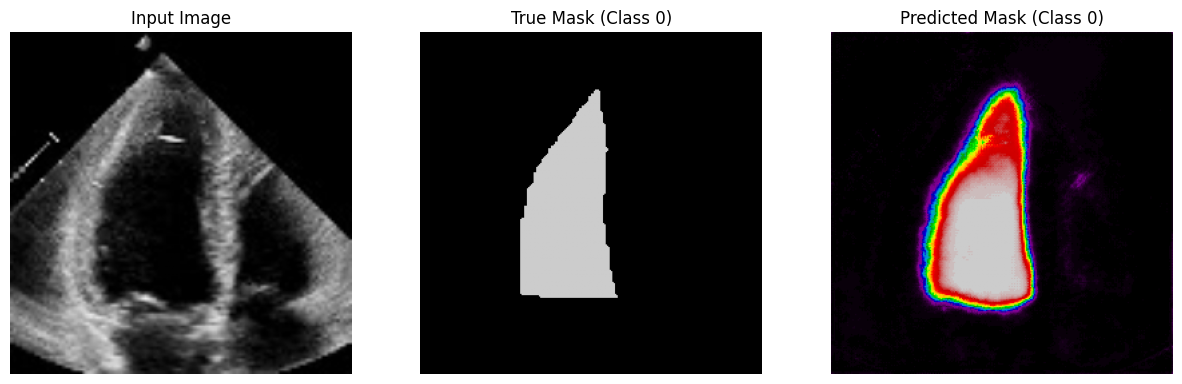

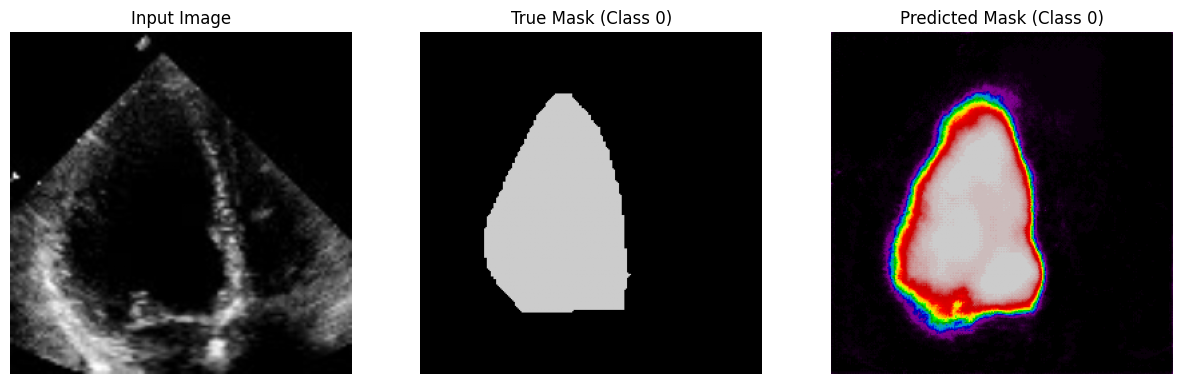

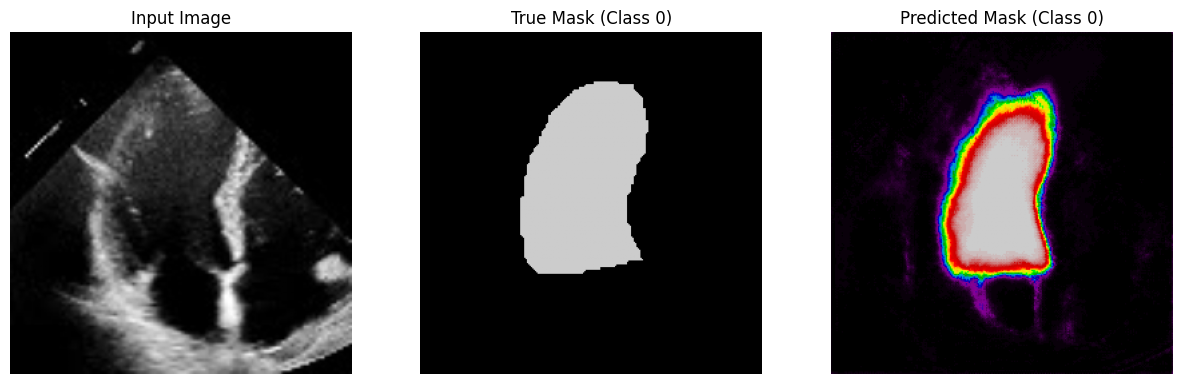

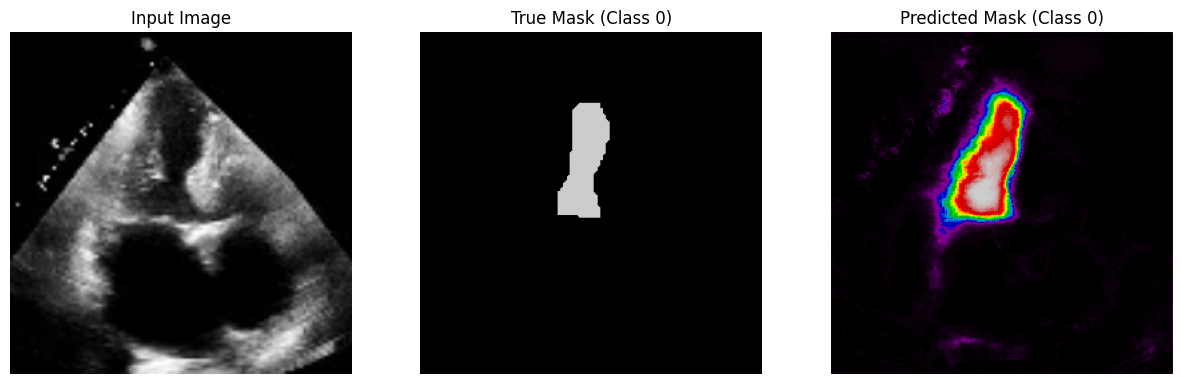

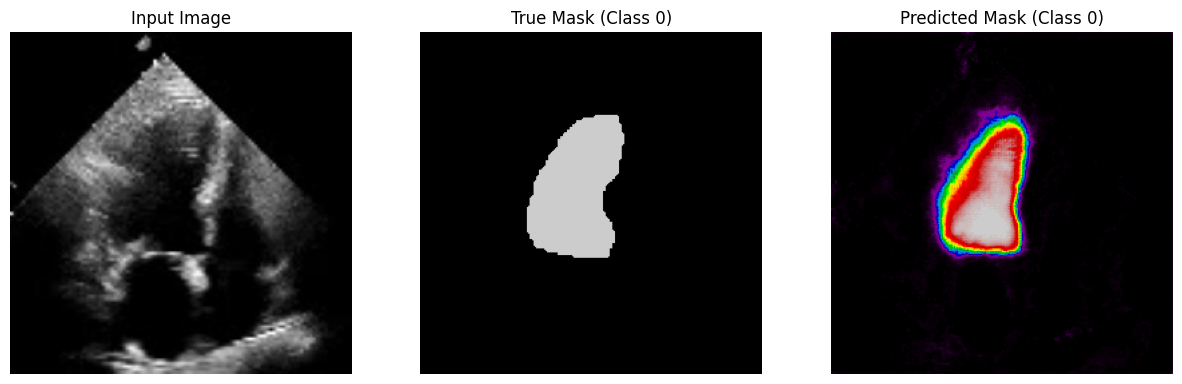

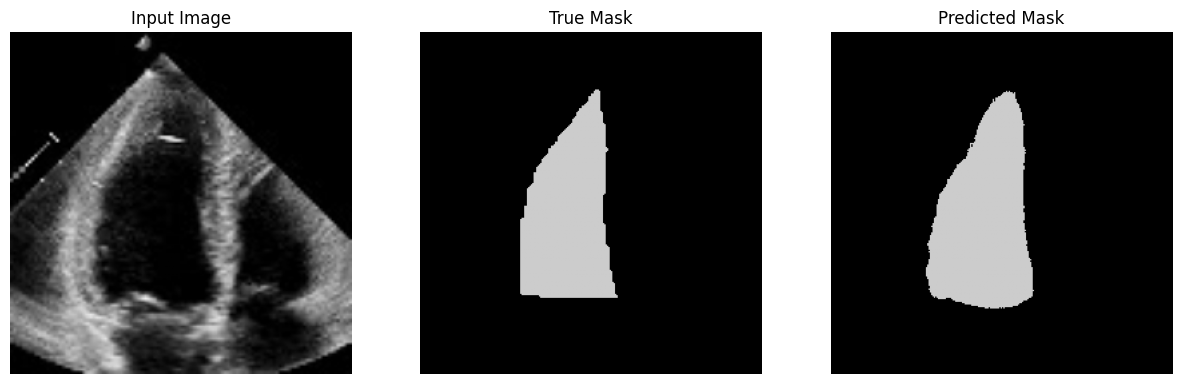

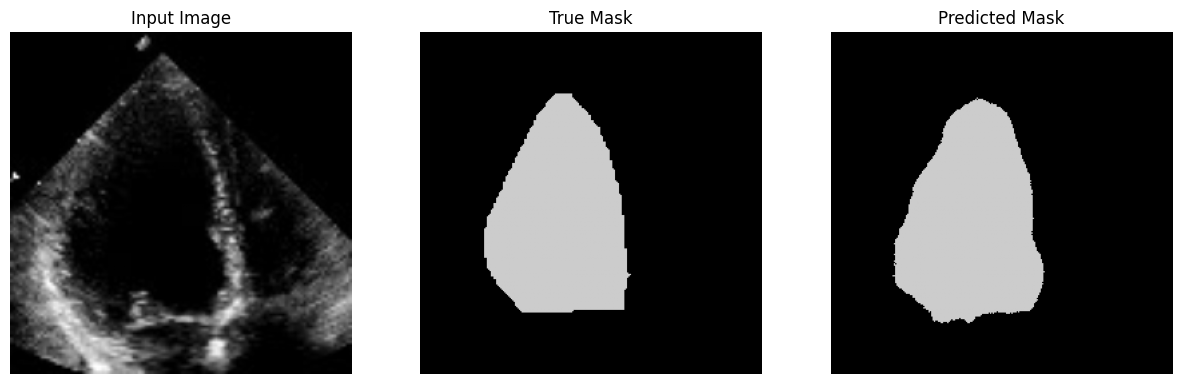

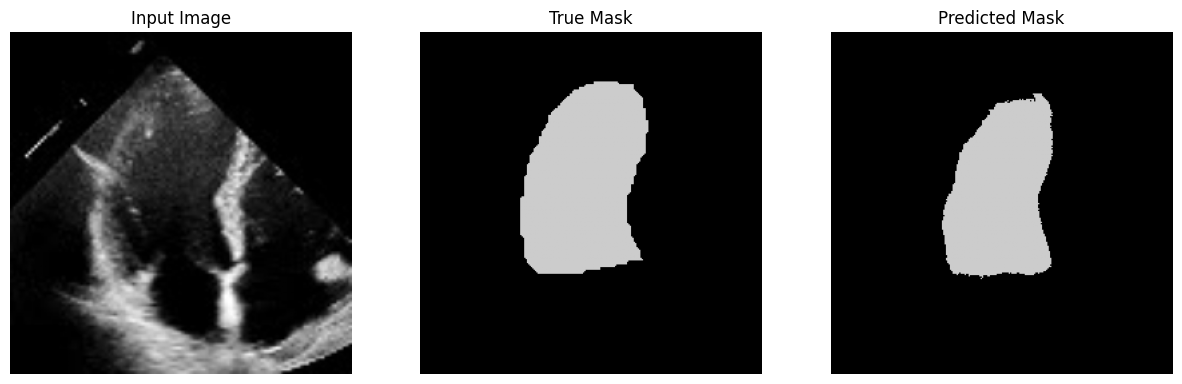

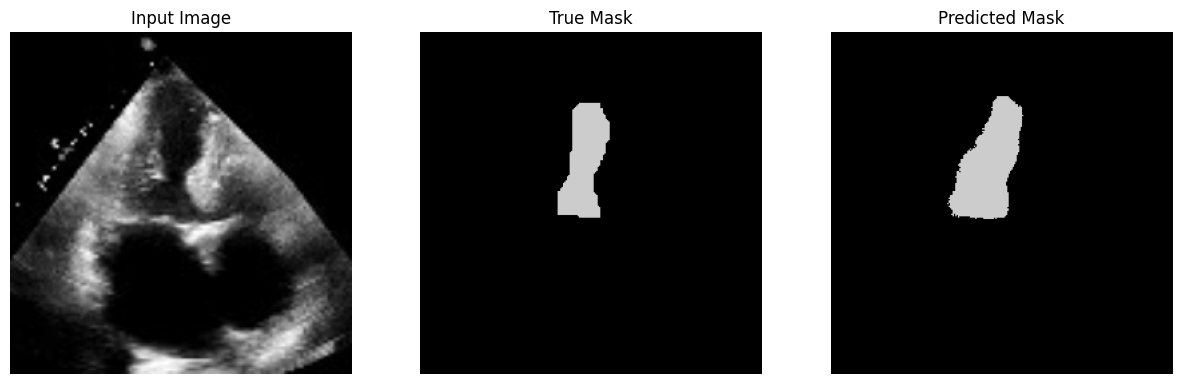

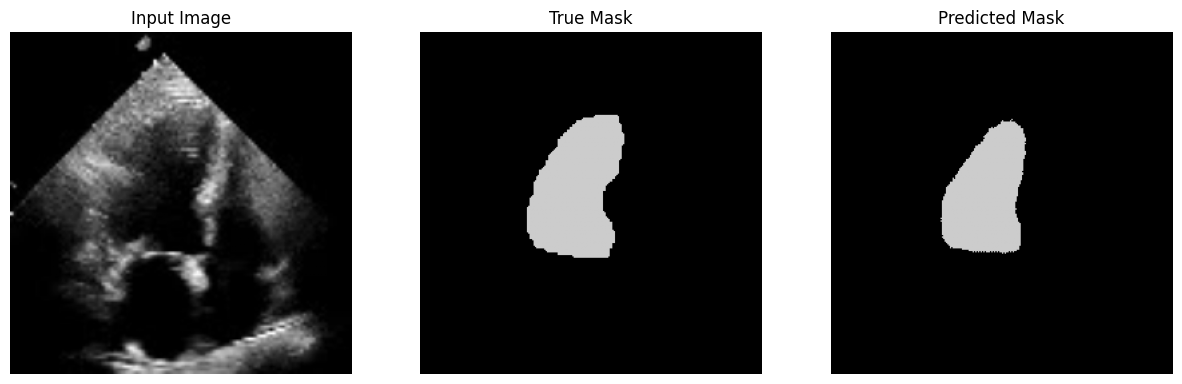

iou_per_class [0.8424671292304993] dice_per_class [0.9144989252090454]
iou_per_class [0.8377262353897095] dice_per_class [0.9116986393928528]
iou_per_class [0.8397310376167297] dice_per_class [0.912884533405304]


Epoch 98/100: 100%|██████████| 251/251 [07:30<00:00,  1.80s/it]


Epoch 98: Train Loss: 0.0406, Val Loss: 0.0455


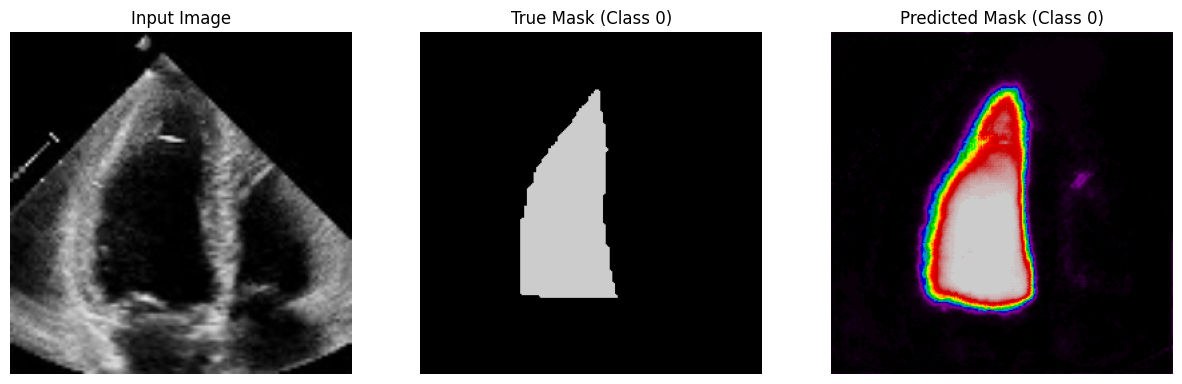

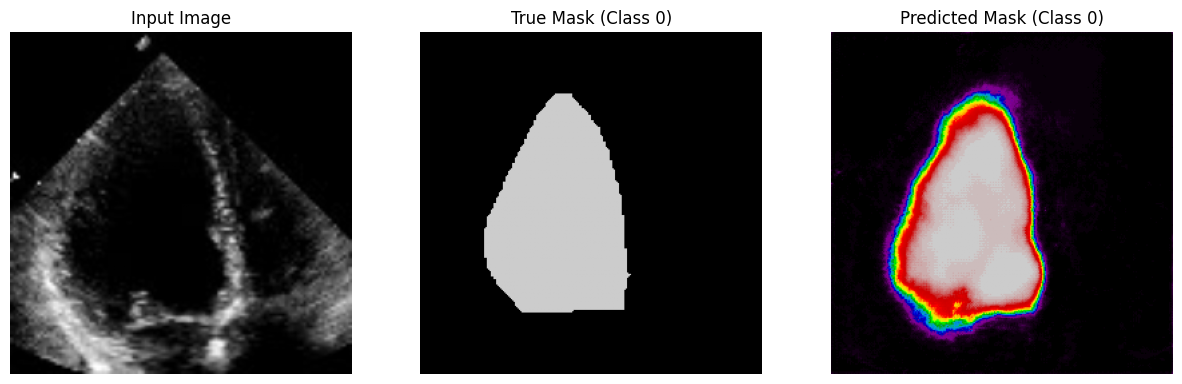

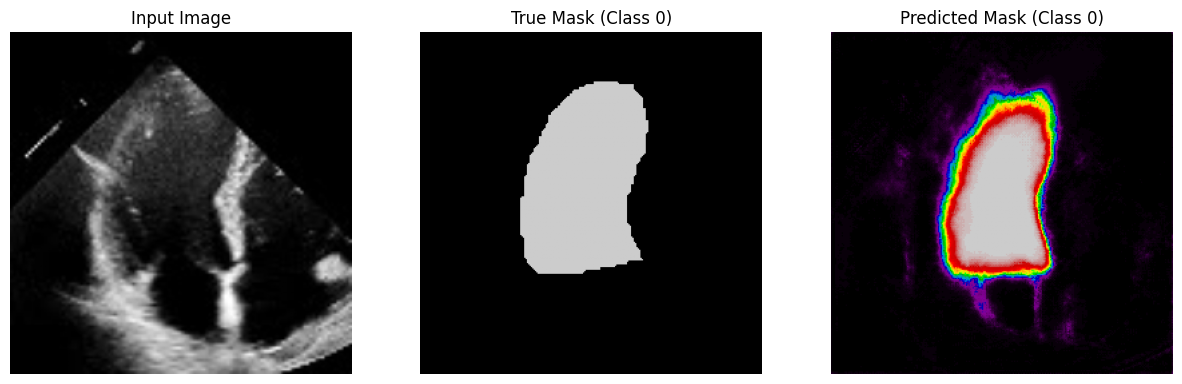

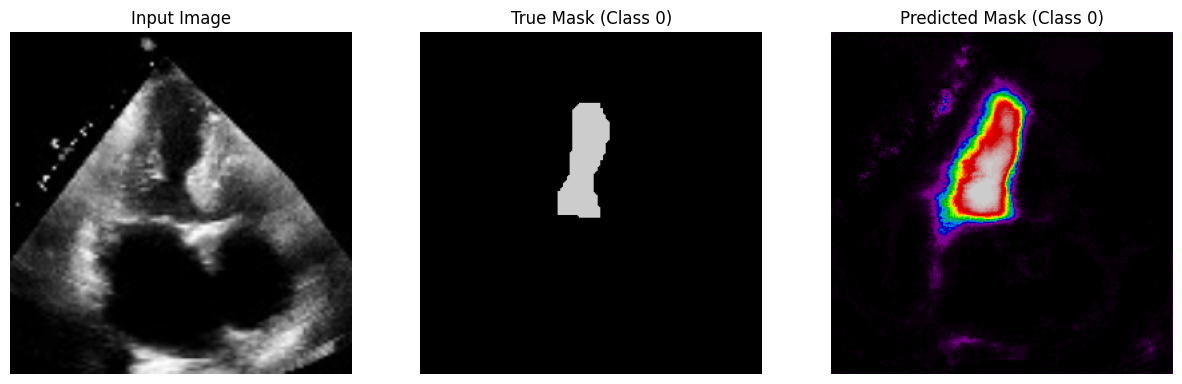

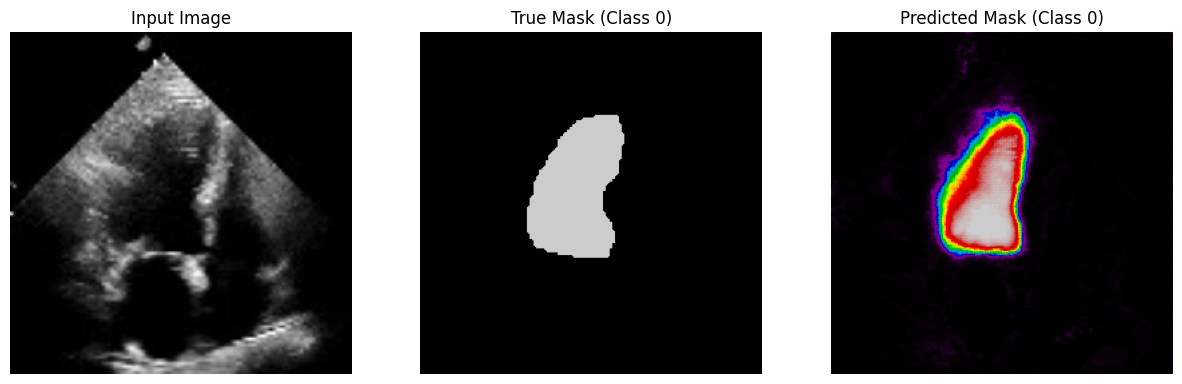

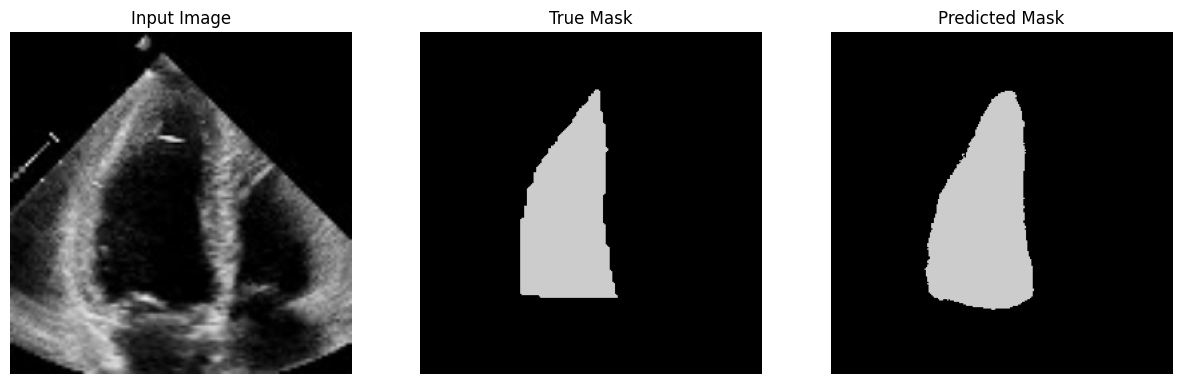

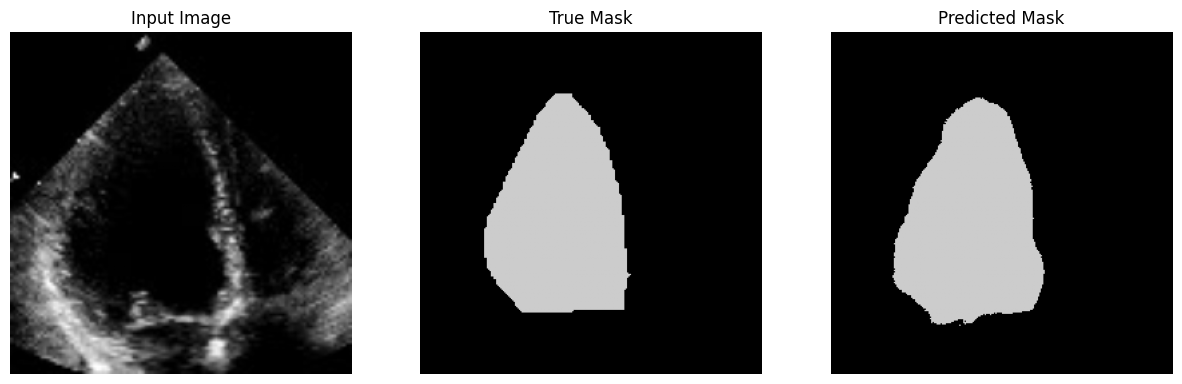

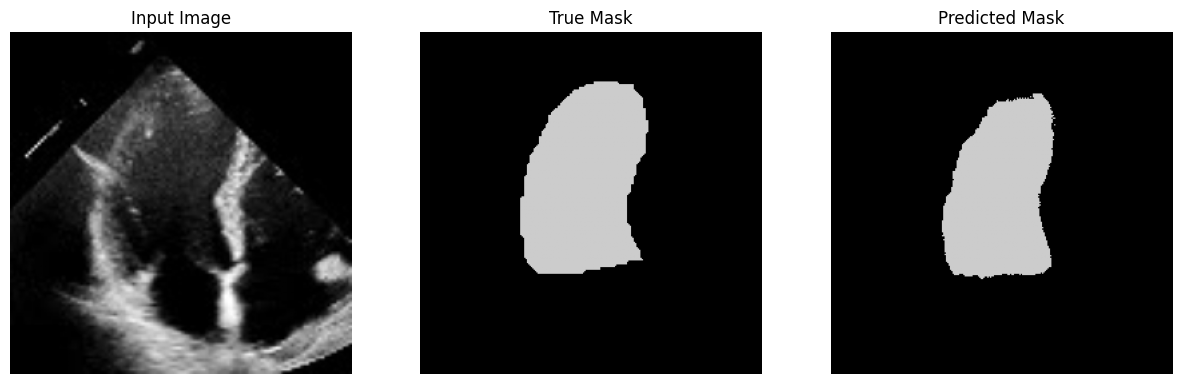

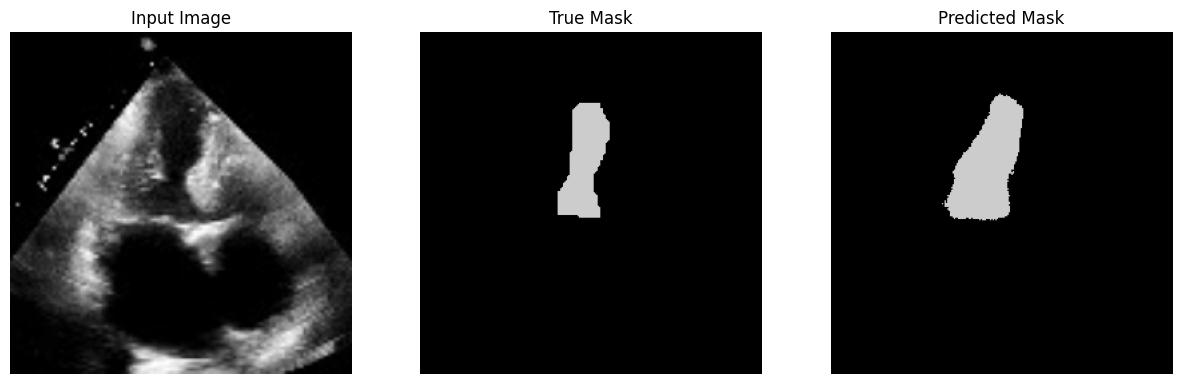

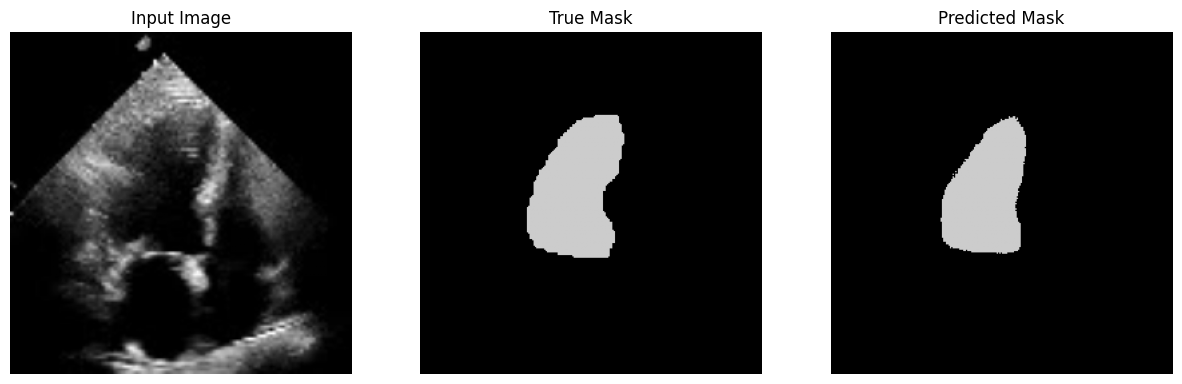

iou_per_class [0.843174397945404] dice_per_class [0.9149155020713806]
iou_per_class [0.8369930982589722] dice_per_class [0.9112643003463745]
iou_per_class [0.8394995927810669] dice_per_class [0.9127478003501892]


Epoch 99/100: 100%|██████████| 251/251 [07:05<00:00,  1.69s/it]


Epoch 99: Train Loss: 0.0405, Val Loss: 0.0455


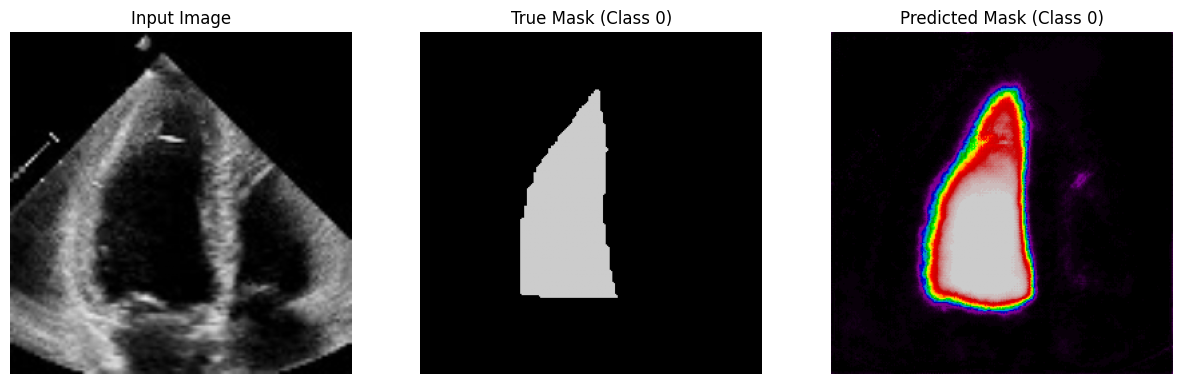

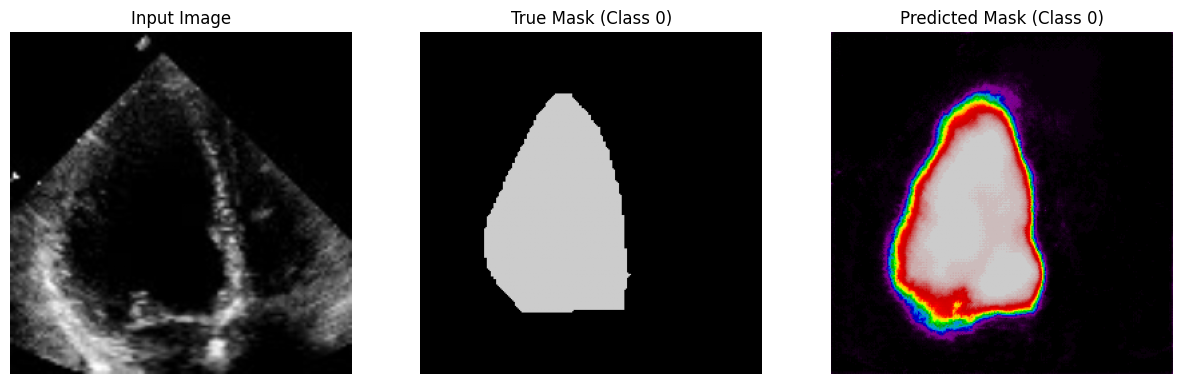

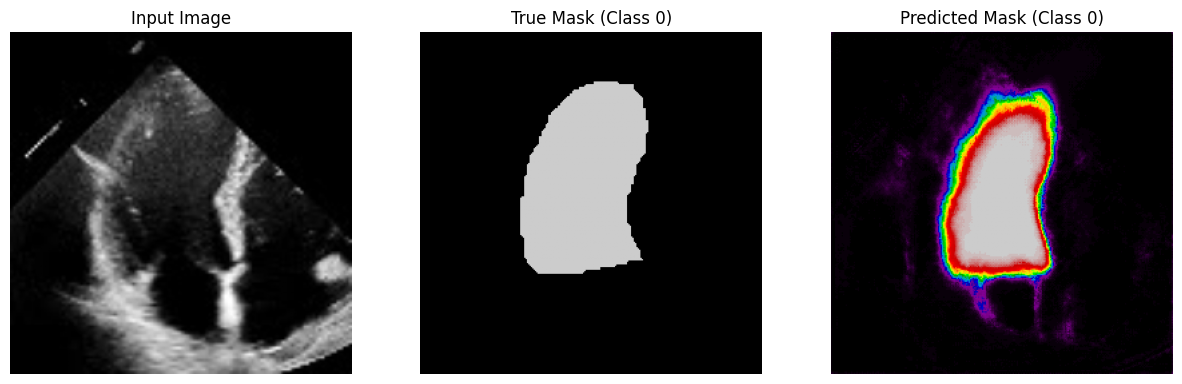

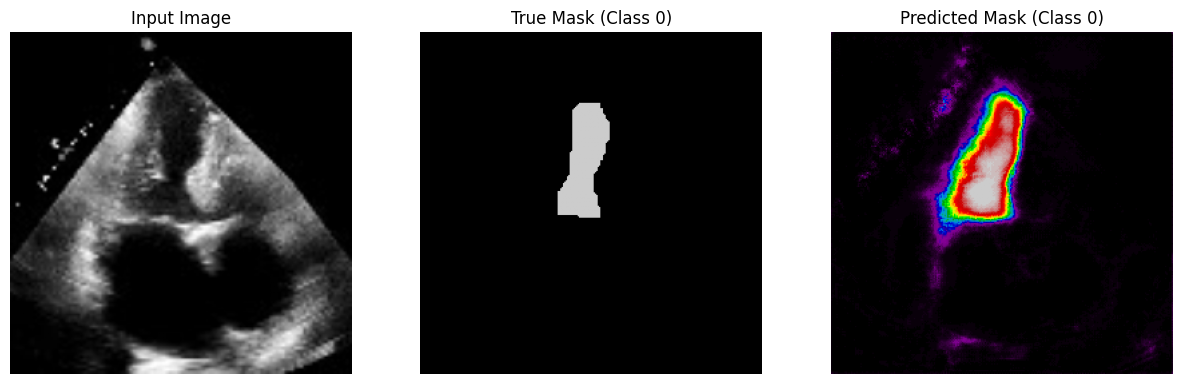

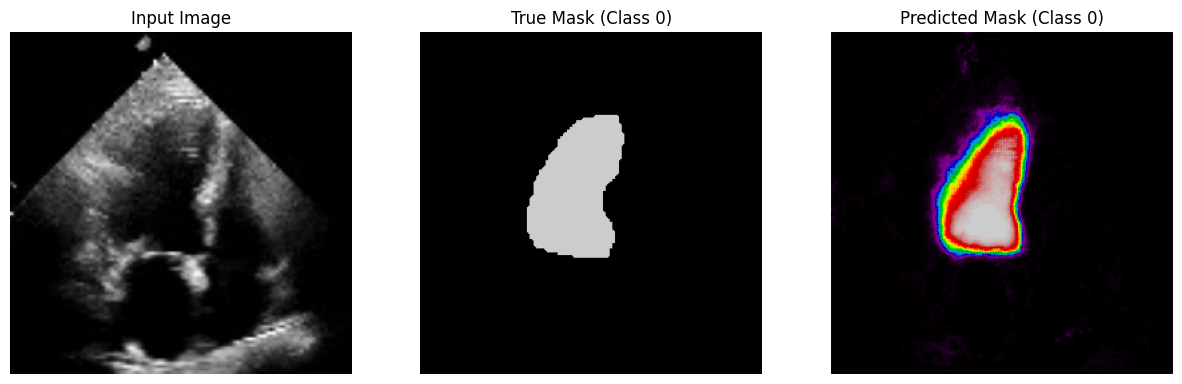

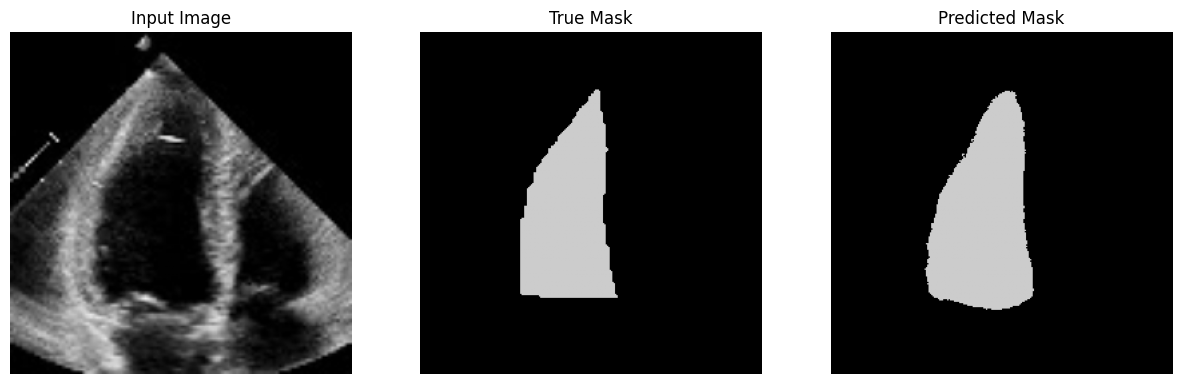

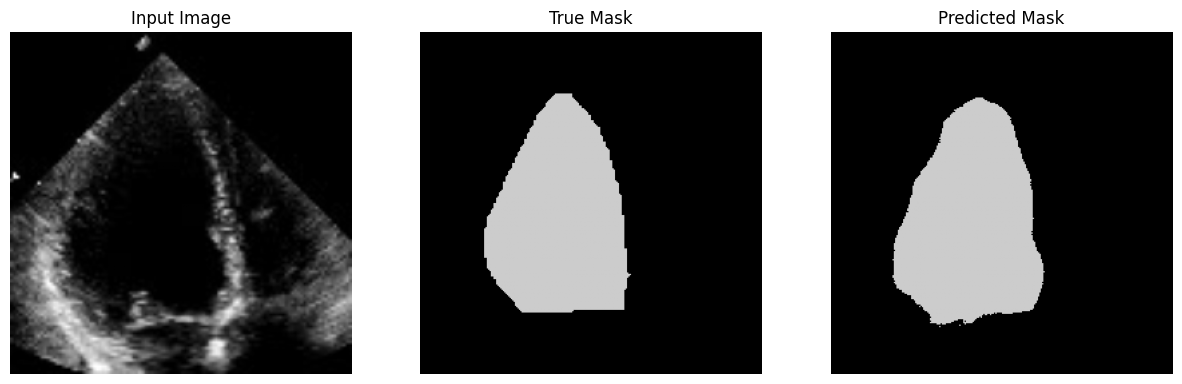

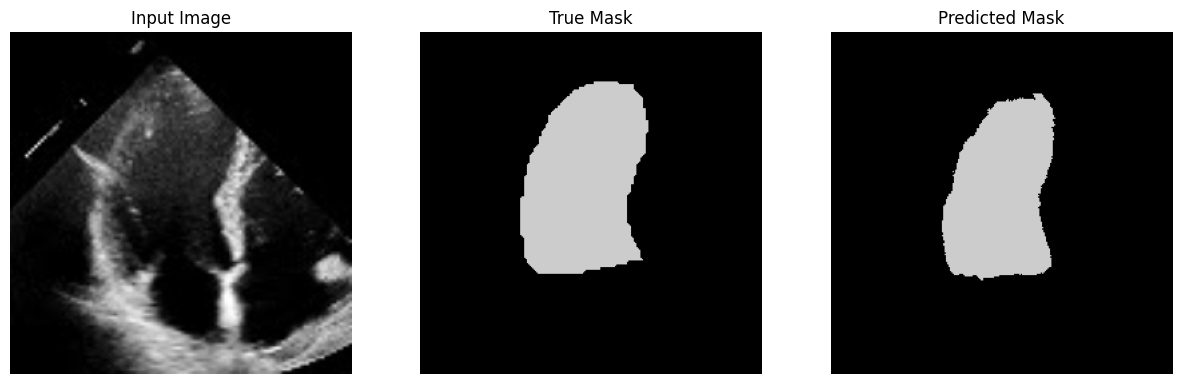

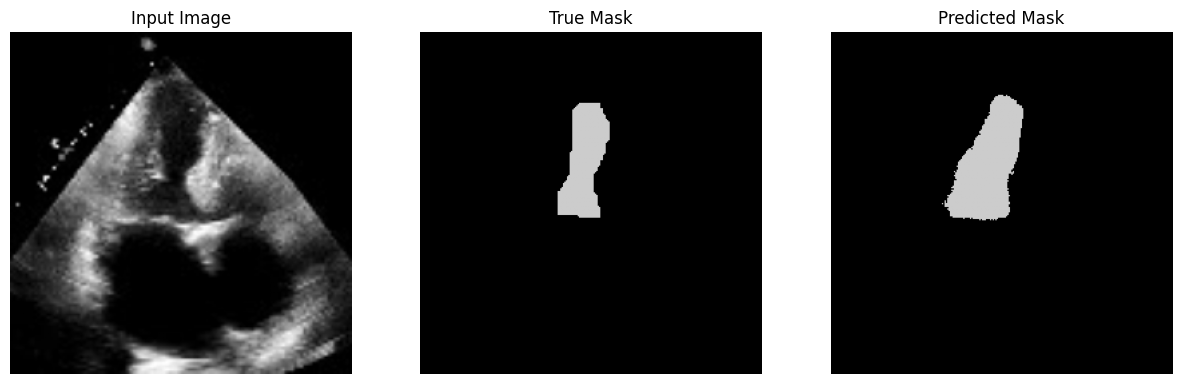

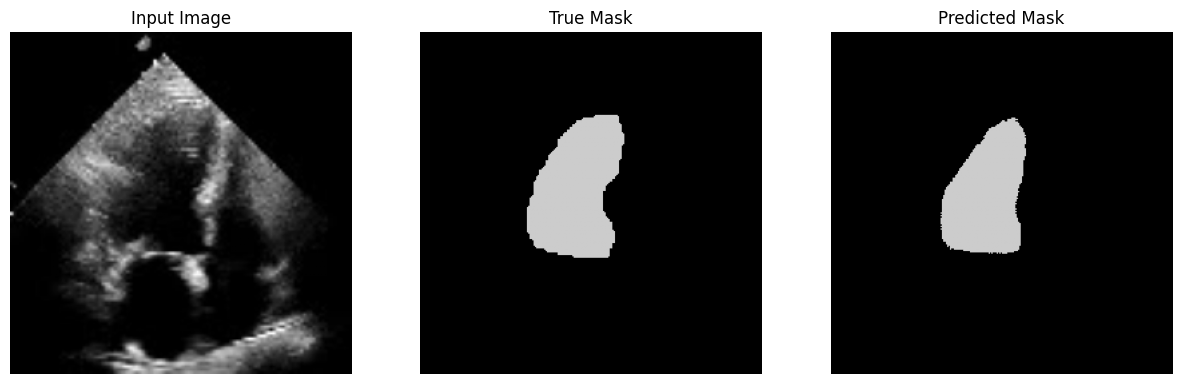

iou_per_class [0.8416978716850281] dice_per_class [0.914045512676239]
iou_per_class [0.8381851315498352] dice_per_class [0.911970317363739]
iou_per_class [0.8410027027130127] dice_per_class [0.9136354923248291]


Epoch 100/100: 100%|██████████| 251/251 [07:09<00:00,  1.71s/it]


Epoch 100: Train Loss: 0.0403, Val Loss: 0.0449


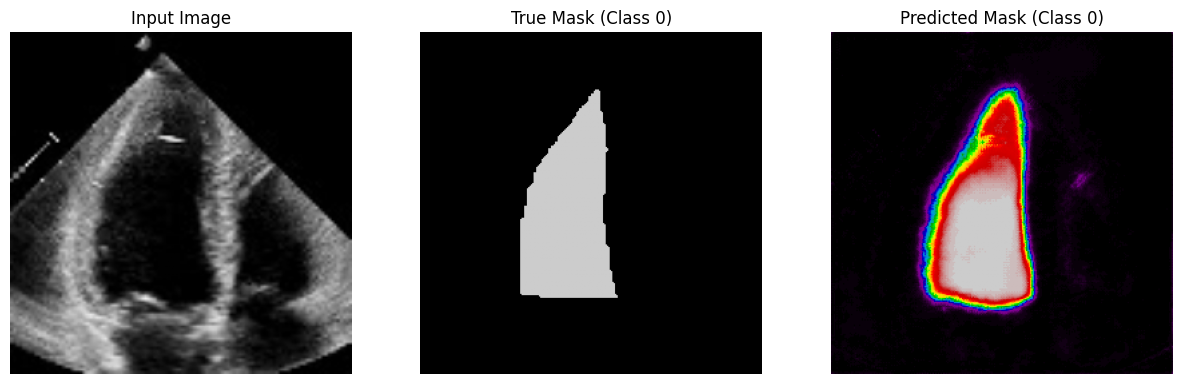

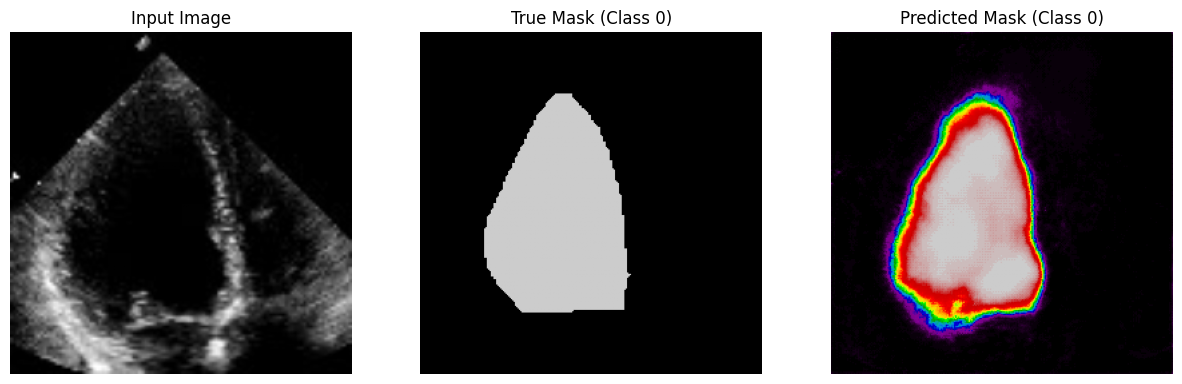

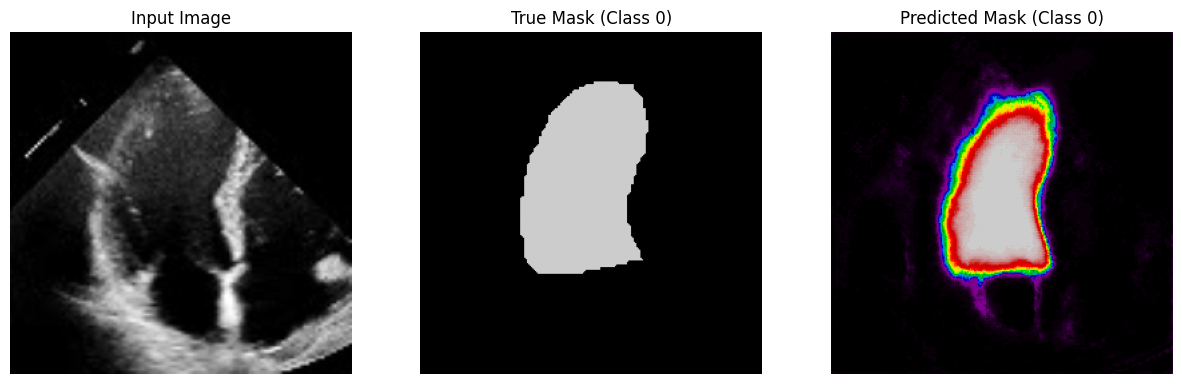

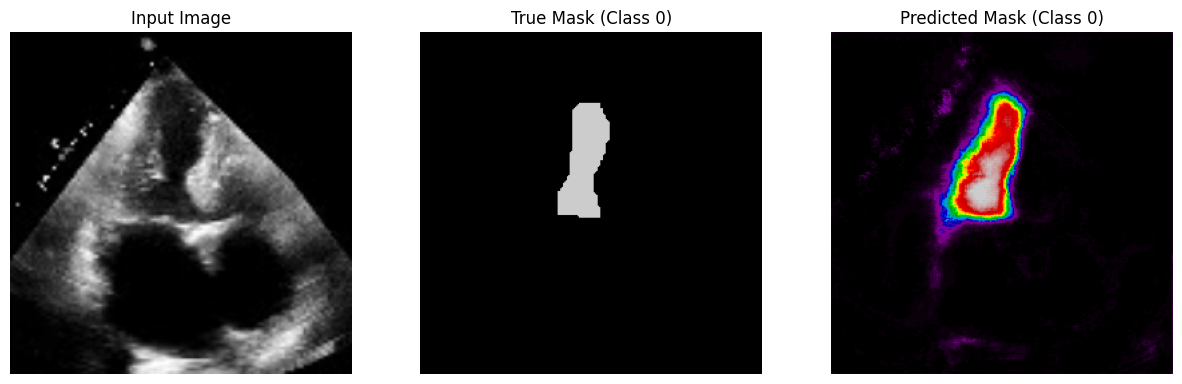

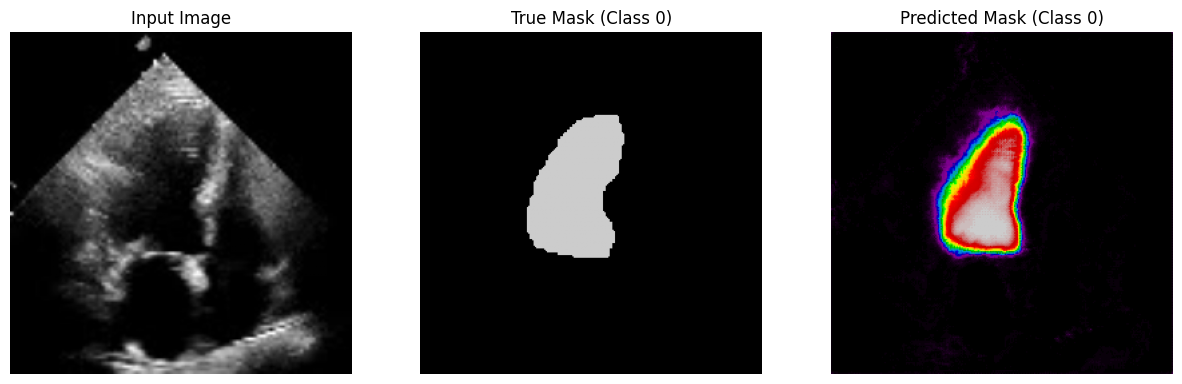

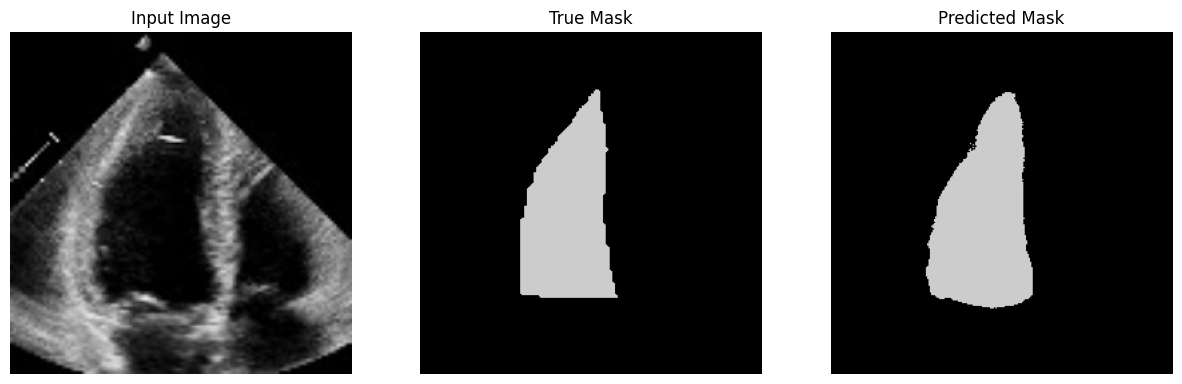

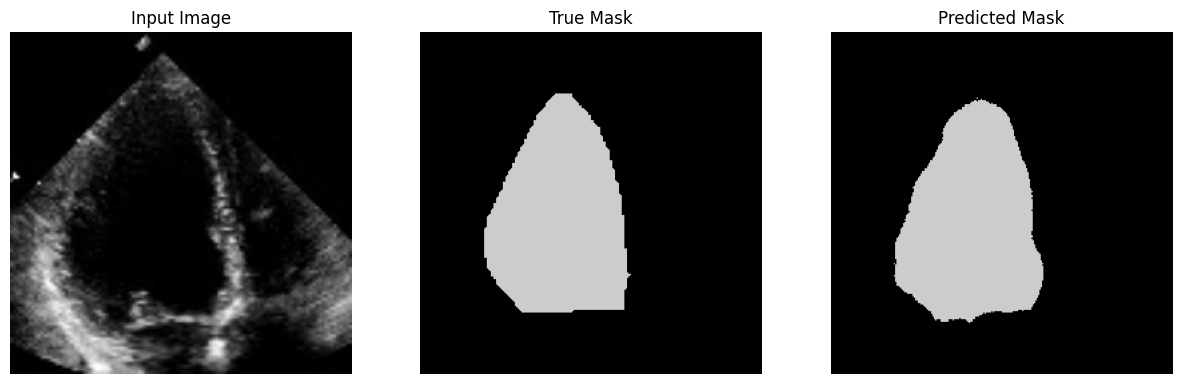

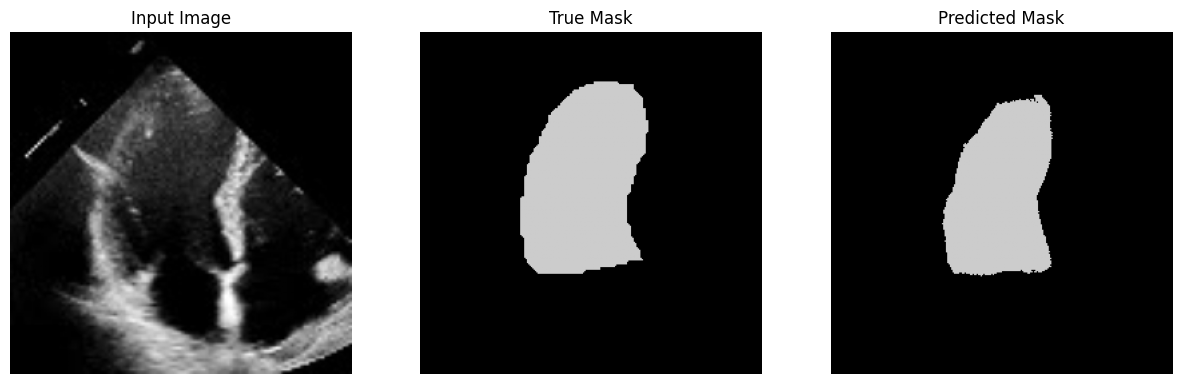

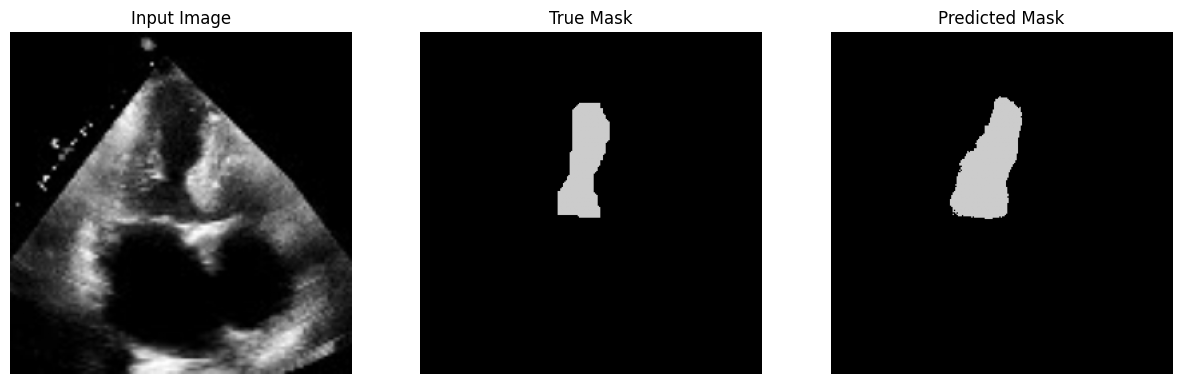

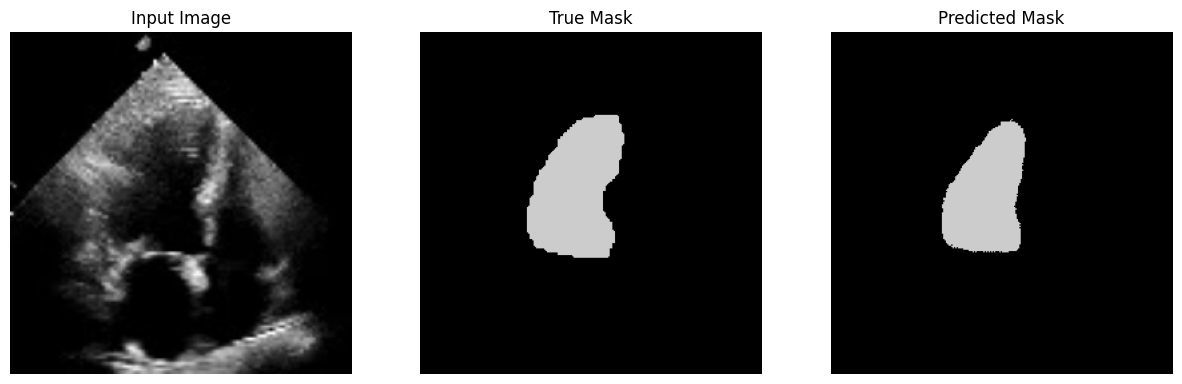

iou_per_class [0.8387820720672607] dice_per_class [0.912323534488678]
iou_per_class [0.8350897431373596] dice_per_class [0.91013503074646]
iou_per_class [0.8382158279418945] dice_per_class [0.9119884967803955]
iou_per_class [0.8199852705001831] dice_per_class [0.9010900259017944]
iou_per_class [0.8183853626251221] dice_per_class [0.900123119354248]
iou_per_class [0.8319665193557739] dice_per_class [0.9082769751548767]
iou_per_class [0.804381251335144] dice_per_class [0.8915867805480957]
iou_per_class [0.8051415681838989] dice_per_class [0.8920536637306213]
iou_per_class [0.8213016986846924] dice_per_class [0.9018843173980713]
iou_per_class [0.8122854828834534] dice_per_class [0.8964210748672485]
iou_per_class [0.8201552629470825] dice_per_class [0.9011926651000977]
iou_per_class [0.8442692160606384] dice_per_class [0.9155595898628235]
iou_per_class [0.8180021643638611] dice_per_class [0.8998913168907166]
iou_per_class [0.8066360950469971] dice_per_class [0.8929702043533325]
iou_per_cla

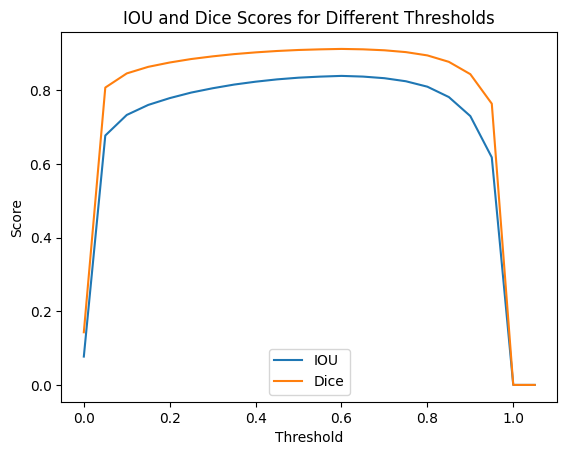

Best Threshold: 0.6000000000000001
Best IOU: 0.8394296765327454
Best Dice: 0.9127064943313599


In [ ]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

def compute_iou_and_dice(pred, target, num_classes, threshold=0.5):
    """
    計算 IOU 和 Dice 指數，並使用閾值將預測轉換為二進制（0 或 1）結果。
    :param pred: 模型預測結果 (batch_size, num_classes, height, width)
    :param target: 目標標註結果 (batch_size, num_classes, height, width)
    :param num_classes: 類別數量
    :param threshold: 用來將預測轉換為二進制結果的閾值 (預設為 0.5)
    :return: 每個類別的 IOU 和 Dice 指數
    """
    iou_per_class = []
    dice_per_class = []
    
    # 將預測轉換為二進制結果（閾值化）
    pred = (pred > threshold).float()  # Apply threshold to get binary result (0 or 1)

    for i in range(num_classes):
        # 取得每個類別的預測結果和真實標註
        pred_i = (pred == i+1).float()
        target_i = (target == i+1).float()

        # 計算交集和聯集
        intersection = (pred_i * target_i).sum()
        union = pred_i.sum() + target_i.sum()
        iou = intersection / (union - intersection) if union != 0 else torch.tensor(0.0)

        # 計算 Dice 指數
        dice = (2 * intersection) / (pred_i.sum() + target_i.sum()) if (pred_i.sum() + target_i.sum()) != 0 else torch.tensor(0.0)

        iou_per_class.append(iou.item())
        dice_per_class.append(dice.item())
    
    return iou_per_class, dice_per_class

def find_best_threshold(pred, target, num_classes, thresholds=np.arange(0.0, 1.1, 0.05)):
    """
    測試不同閾值並找出最佳閾值。
    :param pred: 模型預測結果 (batch_size, num_classes, height, width)
    :param target: 目標標註結果 (batch_size, num_classes, height, width)
    :param num_classes: 類別數量
    :param thresholds: 測試的閾值範圍
    :return: 最佳閾值
    """
    best_threshold = 0.5
    best_iou = 0
    best_dice = 0

    iou_list = []
    dice_list = []
    
    for threshold in thresholds:
        iou_per_class, dice_per_class = compute_iou_and_dice(pred, target, num_classes, threshold)
        
        avg_iou = np.mean(iou_per_class)
        avg_dice = np.mean(dice_per_class)
        
        iou_list.append(avg_iou)
        dice_list.append(avg_dice)
        
        # Find the threshold with the highest IOU and Dice
        if avg_iou > best_iou:
            best_iou = avg_iou
            best_threshold = threshold
        
        if avg_dice > best_dice:
            best_dice = avg_dice
            best_threshold = threshold
    
    # Plot IOU and Dice for each threshold
    import matplotlib.pyplot as plt
    plt.plot(thresholds, iou_list, label='IOU')
    plt.plot(thresholds, dice_list, label='Dice')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.legend()
    plt.title('IOU and Dice Scores for Different Thresholds')
    plt.show()
    
    return best_threshold, best_iou, best_dice

def display_image(image, ax, title="Input Image"):
    """
    Display a single image with grayscale to RGB conversion for visualization.
    """
    ax.imshow(image, cmap='gray')
    ax.set_title(title)
    ax.axis('off')

def display_mask(mask, ax, title="Mask"):
    """
    Display the mask using a color map (e.g., 'nipy_spectral').
    """
    ax.imshow(mask, cmap='nipy_spectral')  # Using 'nipy_spectral' for multi-class visualization
    ax.set_title(title)
    ax.axis('off')

def visualize_results(images, true_masks, predicted_masks, num_displayed=0, max_display=5):
    """
    Visualize the input image, true mask, and predicted mask.
    """
    for i in range(min(max_display, images.size(0))):  # Limit to max_display images
        sample_image = images[i].cpu().numpy().squeeze()  # Remove channel dimension for display
        sample_true_mask = true_masks[i].cpu().numpy()  # Get the true mask (multi-channel)
        sample_pred_mask = predicted_masks[i].cpu().numpy()  # Get the predicted mask (multi-channel)

        # Plot the input image, true mask, and predicted mask side by side
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # Display input image
        display_image(sample_image, axes[0], "Input Image")

        # Display true mask for each class
        for class_idx in range(sample_true_mask.shape[0]):  # Loop through the channels (classes)
            display_mask(sample_true_mask[class_idx], axes[1], f"True Mask (Class {class_idx})")
            break  # Only show the first class mask for now

        # Display predicted mask for each class
        for class_idx in range(sample_pred_mask.shape[0]):  # Loop through the channels (classes)
            display_mask(sample_pred_mask[class_idx], axes[2], f"Predicted Mask (Class {class_idx})")
            break  # Only show the first class mask for now

        plt.show()
        num_displayed += 1  # Update the display count

    return num_displayed

def visualize_results_binary(images, true_masks, predicted_masks, num_displayed=0, max_display=5):
    """
    Visualize the input image, true mask, and predicted mask.
    """
    for i in range(min(max_display, images.size(0))):  # Limit to max_display images
        sample_image = images[i].cpu().numpy().squeeze()  # Remove channel dimension for display
        sample_true_mask = true_masks[i].cpu().numpy().squeeze()  # Remove channel dimension for display
        sample_pred_mask = predicted_masks[i].cpu().numpy().squeeze()  # Remove channel dimension for display

        # Binarize predicted mask for binary classification (0 or 1)
        sample_pred_mask = (sample_pred_mask > 0.5).astype(np.uint8)  # Binarize prediction

        # Plot the input image, true mask, and predicted mask side by side
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # Display input image
        display_image(sample_image, axes[0], "Input Image")

        # Display true mask
        display_mask(sample_true_mask, axes[1], f"True Mask")

        # Display predicted mask
        display_mask(sample_pred_mask, axes[2], f"Predicted Mask")

        plt.show()
        num_displayed += 1  # Update the display count

    return num_displayed



# 轉換 Windows 路徑至適合的格式
def convert_path(path):
    return path.replace('\\', '/')

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

# 定義 U-Net 模型（修改為二分類問題，每個類別作為二分類處理）
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)
        # self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

class ImageMaskDataset(Dataset):
    def __init__(self, frames_dir, masks_dir, file_list, transform=None):
        """
        :param frames_dir: 原始影像的資料夾路徑
        :param masks_dir: 遮罩影像的資料夾路徑
        :param file_list: 包含影像檔案名稱的列表（不包含路徑）
        :param transform: 資料增強的轉換方法
        """
        self.frames_dir = frames_dir
        self.masks_dir = masks_dir
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        frame_path = os.path.join(self.frames_dir, self.file_list[idx])
        mask_path = os.path.join(self.masks_dir, self.file_list[idx])

        # 讀取影像和遮罩
        frame = Image.open(frame_path).convert('L')  # 原始影像轉為 RGB
        mask = Image.open(mask_path).convert('L')  # 遮罩影像轉為單通道灰度

        if self.transform:
            frame = self.transform(frame)
            mask = self.transform(mask)

        # 將遮罩轉為二值格式
        mask = (mask > 0.5).float()  # 將像素值轉為二進制

        return frame, mask

# 訓練函數
def train():
    # 設定路徑
    frames_dir = "mask_and_label_frame/frames"
    masks_dir = "mask_and_label_frame/masks"

    # 分割數據集
    all_filenames = [f for f in os.listdir(frames_dir) if f.endswith('.png')]
    train_filenames, temp_filenames = train_test_split(all_filenames, test_size=0.2, random_state=42)
    val_filenames, test_filenames = train_test_split(temp_filenames, test_size=0.5, random_state=42)

    print(f"訓練集大小: {len(train_filenames)}")
    print(f"驗證集大小: {len(val_filenames)}")
    print(f"測試集大小: {len(test_filenames)}")

    # 定義資料增強與轉換
    transform = transforms.Compose([
        transforms.Resize((112, 112)),  # 確保影像大小一致
        transforms.RandomHorizontalFlip(p=1.0),
        transforms.ToTensor(),         # 轉為 Tensor
    ])

    # 創建數據集
    train_dataset = ImageMaskDataset(frames_dir, masks_dir, train_filenames, transform)
    val_dataset = ImageMaskDataset(frames_dir, masks_dir, val_filenames, transform)
    test_dataset = ImageMaskDataset(frames_dir, masks_dir, test_filenames, transform)

    # 創建 DataLoader
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    print("DataLoader 建立完成")

    # 初始化模型
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = UNet(1, 1).to(device)

    
    # 嘗試加載預訓練權重
    model_path = f'unet_best_model_LV_HorizontalFlip.pth'
    if os.path.exists(model_path):
        model.load_state_dict(torch.load(model_path))  # 加載預訓練的權重
        print(f"Loaded pretrained weights for LV from {model_path}")
    else:
        print(f"No pretrained weights found for LV HorizontalFlip. Training from scratch.")


    # 設置損失函數和優化器
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001)

    # 訓練模型
    num_epochs = 100
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for images, masks in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)

            loss = criterion(outputs, masks)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)

        # 驗證模型
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)

                loss = criterion(outputs, masks)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        print(f'Epoch {epoch + 1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

        # 儲存模型
        torch.save(model.state_dict(), f'unet_latest_model_LV_HorizontalFlip.pth')

        # 儲存最佳模型
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'unet_best_model_LV_HorizontalFlip.pth')

        # 測試模型
        model.eval()
        iou_per_class_total = 0
        dice_per_class_total = 0
        num_batches = 0

        with torch.no_grad():
            for images, masks in test_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                predicted = torch.sigmoid(outputs)  # 轉換為二進制結果

                # 顯示前五張範例圖像與預測結果
                if num_batches == 0 and num_epochs - epoch < 5:  # 只顯示第一批
                    visualize_results(images, masks, predicted, num_displayed=0, max_display=5)
                    visualize_results_binary(images, masks, predicted, num_displayed=0, max_display=5)

                # 計算 IOU 和 Dice 指數
                iou_per_class, dice_per_class = compute_iou_and_dice(predicted, masks, 1)  # 這裡只有一個類別
                print('iou_per_class', iou_per_class, 'dice_per_class', dice_per_class)

                iou_per_class_total += np.array(iou_per_class)
                dice_per_class_total += np.array(dice_per_class)
                num_batches += 1

                if num_batches == 3 and epoch != num_epochs - 1:
                    break

    # 計算平均 IOU 和 Dice
    iou_per_class_avg = iou_per_class_total / num_batches
    dice_per_class_avg = dice_per_class_total / num_batches
    print(f'IOU: {iou_per_class_avg[0]:.4f}, Dice: {dice_per_class_avg[0]:.4f}')

    best_threshold, best_iou, best_dice = find_best_threshold(predicted, masks, 1)
    print(f"Best Threshold: {best_threshold}")
    print(f"Best IOU: {best_iou}")
    print(f"Best Dice: {best_dice}")

if __name__ == "__main__":
    train()

